# Documentation

In this step we train a LayoutLM model on our Dataset. The following method is inpired from this code: https://github.com/manikanthp/LayoutLMV3_Fine_Tuning.

# Installing Libraries

In [ ]:
! pip install paddleocr
! pip install paddlepaddle
! pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.7/465.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 18.3 MB/s

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=742ebaf6e5c21c18f27d66b4bc27c41fec4ff83dacc66069952818029445cfa1
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


# Loading and Formating the Data

## Setting the Working Directory

In [ ]:
import os

# set the working directory (this version is created for Google Colab)
my_wd = "/content"
os.chdir(my_wd)
print("Changed working directory to:", os.getcwd())

Changed working directory to: /content


## Mounting Google Drive

In [ ]:
from google.colab import drive

# mount google drive
drive.mount(os.path.join(my_wd,"drive"))

Mounted at /content/drive


## Loading and Unzipping the Folder Containing our 180 Invoices

In [ ]:
# define the google drive location
drive_location = "drive/your_path.zip"

# create the final path
zip_file_path = os.path.join(my_wd, drive_location)

# keep the name of the zipped folder
zip_basename = os.path.splitext(os.path.basename(drive_location))[0]

# unzip the folder
!unzip -q "{zip_file_path}" -d "{zip_basename}"

# Transforming the JSON-MIN file

## Creating the Necessary Functions for the JSON Transformation

The documentation for LayoutLM (https://huggingface.co/transformers/v4.4.2/model_doc/layoutlm.html#overview) recommends normalizing bounding boxes. This means that the coordinates of bounding boxes should be represented relative to the size of the document. However, it's worth noting that in the Label Studio JSON-MIN format (https://labelstud.io/guide/export.html#Label-Studio-JSON-format-of-annotated-tasks), bounding box information is already provided in a normalized form (displayed below).

* x = x / 100.0 * original_width
* y = y / 100.0 * original_height
* width = width / 100.0 * original_width
* height = height / 100.0 * original_height

In the Label Studio JSON format, the properties "original_width" and "original_height" represent the dimensions of the entire document, while "width" and "height" correspond to the size of the bounding box. This pre-existing normalization aligns with the expectations of LayoutLM, simplifying the integration of annotated tasks into the model.




Finally the JSON-MIN exported from the Label Studio gives as the following normilized results according to documendation (https://labelstud.io/tags/rectanglelabels)

* x: The x-coordinate of the top-left corner of the bounding box.
* y: The y-coordinate of the top-left corner of the bounding box.
* width: The width of the bbox
* height: The height of the bbox

To ensure compatibility with the LayoutLM model, was created a custom transformation function `convert_bounding_boxes_in_LayoutLM_format`. This function adapts the bounding box coordinates from the Label Studio JSON-MIN format (https://labelstud.io/guide/export.html#Label-Studio-JSON-format-of-annotated-tasks) to meet the specifications outlined in the LayoutLM documentation (https://huggingface.co/transformers/v4.4.2/model_doc/layoutlm.html#overview).

* x1: Represents the x-coordinate of the bottom-left corner of the bounding box.
* y1: Represents the y-coordinate of the top-left corner of the bounding box.
* x2: Represents the x-coordinate of the top-right corner of the bounding box.
* y2: Represents the y-coordinate of the bottom-right corner of the bounding box.

In [ ]:
# define the function to convert bounding boxes to yolo format
def convert_bounding_boxes_in_LayoutLM_format(x, y, width, height):
      x1 = x   # x-coordinate of the top-left corner
      y1 = y   # y-coordinate of the top-left corner
      x2 = x + width  # x-coordinate of the bottom-right corner
      y2 = y + height  # y-coordinate of the bottom-right corner

    # Return the bounding box coordinates in YOLO format [x1, y1, x2, y2]
      return [x1, y1, x2, y2]

The function `convert_annotations_to_json` thoughtfully organizes the JSON file created in the prior step to adhere to the LayoutLM restrictions. It extracts crucial details such as file name, image dimensions, bounding box coordinates, texts, and labels. This data is thoughtfully structured into a list of dictionaries, with each dictionary representing an annotated image.

In [ ]:
import json
import os

def convert_annotations_to_json(input_json_path, output_json_path):

    # load json data from the specified file
    with open(input_json_path) as f:
        data = json.load(f)

    # initialize the output list to store formatted data
    output = []

    # process each annotated image in the loaded data
    for annotated_image in data:
        # initialize a dictionary to store information about the current image
        image_data = {}
        annotations_list = []

        # iterate through key-value pairs in the annotated image
        for key, value in annotated_image.items():
            if key == 'ocr':
                # extract the ocr file name and format the file path
                value = value.split('8080/')[-1]
                image_data["file_name"] = f"/content/your_path/{value}"
                output.append(image_data)
            elif key == 'bbox':
                # extract width and height of the document
                width = value[0]['original_width']
                height = value[0]['original_height']
                image_data["height"] = height
                image_data["width"] = width
            elif key in ['bbox', 'transcription', 'label']:
                # process bounding box, transcription, and label information
                for bb, text, label in zip(annotated_image['bbox'], annotated_image['transcription'], annotated_image['label']):
                    annotation_dict = {
                        "box": convert_bounding_boxes_in_LayoutLM_format(bb['x'], bb['y'], bb['width'], bb['height']), # convert from Label Studio Format to LayoutLM acceptable one
                        "text": text,
                        "label": label['labels'][-1]
                    }
                    annotations_list.append(annotation_dict)

        # store the list of annotations in the image_data dictionary
        image_data["annotations"] = annotations_list

    # write the formatted data to a new json file
    with open(output_json_path, "w") as f:
        json.dump(output, f, indent=4)

		# print statement indicating completion
    print("Conversion completed successfully.")


## Utilizing the Functions

In [ ]:
# define the google drive location
drive_location = "drive/your_project_after_labels_replacements.json"

# create the final input path
input_path = os.path.join(my_wd, drive_location)

# define the JSON name
output_path = "Training_layoutLMV3.json"

# create the final output path
output_path = os.path.join(my_wd, output_path)

# utilize the function
convert_annotations_to_json(input_path, output_path)

Conversion completed successfully.


# Splitting the Dataset

The following code splits the dataset to train, eval and test sets.

* Training Set: Consists of 144 images, representing 80% of the dataset.

* Validation Set: Comprises 18 images, accounting for 10% of the dataset. Used during training for choosing the best model.

* Test Set: Comprises 18 images as well, constituting 10% of the dataset. Reserved for evaluating the model's performance after training on the training set.

In [ ]:
from sklearn.model_selection import train_test_split
import json


final_json = "Training_layoutLMV3.json"

# Load data from the JSON file
with open(os.path.join(my_wd, final_json)) as f:
    data = json.load(f)

# Split data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Save train, validation, and test data to separate JSON files with indentation for readability
with open('train_data.json', 'w') as train_file:
    json.dump(train_data, train_file, indent=4)

with open('val_data.json', 'w') as val_file:
    json.dump(val_data, val_file, indent=4)

with open('test_data.json', 'w') as test_file:
    json.dump(test_data, test_file, indent=4)

# Fine Tuning LayoutLMv3-base

### Define Model

To effectively prepare data for the LayoutLMV3 model, the recommended approach involves harnessing the capabilities of the LayoutLMV3Processor. This versatile tool seamlessly integrates image and text processing functionalities.

Internally, the LayoutLMV3Processor encapsulates a LayoutLMV3FeatureExtractor for managing the image modality and a LayoutLMV3Tokenizer for handling the text modality. The LayoutLMV3FeatureExtractor performs tasks such as resizing and normalizing document images. It also has Optical Character Recognition (OCR) capabilities, although in this context, OCR is excluded since the words and bounding boxes are already obtained through PaddleOCR.

Conversely, the LayoutLMV3TokenizerFast takes words and bounding boxes from our JSON file. It transforms this information into token-level representations, including input_ids, attention_mask, bboxes, and labels for token classification tasks.

Ultimately, the LayoutLMV3Processor seamlessly combines the outputs of the LayoutLMV3FeatureExtractor and LayoutLMV3TokenizerFast, producing a comprehensive dictionary. This dictionary consolidates key information from both components, streamlining the data preparation process for the LayoutLMV3 model.

In the Following Code:

* LayoutLMv3FeatureExtractor is set to ignore OCR functionality (apply_ocr=False).
* LayoutLMv3TokenizerFast is loaded from the pre-trained model and configured to ignore mismatched sizes during tokenization.
* LayoutLMv3Processor is established with the initialized tokenizer and feature extractor, facilitating data preparation for LayoutLMv3 model.


In [ ]:
import torch
from transformers import LayoutLMv3FeatureExtractor, LayoutLMv3TokenizerFast, LayoutLMv3Processor, LayoutLMv3ForTokenClassification
from torch.optim import AdamW

# Initializing LayoutLMv3FeatureExtractor with OCR functionality turned off
featur_extractor = LayoutLMv3FeatureExtractor(apply_ocr=False)

# Loading a pre-trained LayoutLMv3 tokenizer and configuring it to handle tokenization, ignoring mismatched sizes
tokeniser = LayoutLMv3TokenizerFast.from_pretrained("microsoft/layoutlmv3-base", ignore_mismatched_sizes=True)

# Creating a LayoutLMv3Processor, incorporating the initialized tokenizer and feature extractor
processor = LayoutLMv3Processor(tokenizer=tokeniser, feature_extractor=featur_extractor)

/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv3/feature_extraction_layoutlmv3.py:30: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv3/processing_layoutlmv3.py:53: FutureWarning: The `feature_extractor` argument is deprecated and will be removed in v5, use `image_processor` instead.
  warnings.warn(


### Loader

The below dataSet class is designed to facilitate the creation of the dataset for training the LayoutLMv3 model, leveraging the created JSON format for layout-based token classification tasks. The class handles image loading, tokenization, and encoding of the data using the provided processor.

In [ ]:
from PIL import Image

# custom dataset class for LayoutLMv3 model
class dataSet:
    def __init__(self, json_path, processor=None) -> None:
        # reading and formatting JSON data using train_data_format function
        self.json_data = train_data_format(read_json(json_path))

        # processor for encoding images and tokens
        self.processor = processor

    def __len__(self) -> int:
        # returning the length of the dataset
        return len(self.json_data)

    def __getitem__(self, index) -> dict:
        # initializing lists to store image, words, labels, and bounding boxes
        imgs = []
        words = []
        label = []
        bboxes = []

        # extracting data from the JSON dataset at the specified index
        data = self.json_data[index]

        # loading image using PIL and converting to RGB format, words, labeles and bboxes
        imgs.append(Image.open(data['img_path']).convert('RGB'))
        words.append(data['tokens'])
        label.append(data['ner_tag'])
        bboxes.append(data['bboxes'])

        # encoding the data using the provided processor
        encoding = self.processor(
                        imgs,
                        words,
                        boxes=bboxes,
                        max_length=512,
                        word_labels=label,
                        padding="max_length",
                        truncation="longest_first",
                        return_tensors='pt'
                        # return_offsets_mapping=True
                    )

        # returning a dictionary containing tensors for model input
        return {
            "input_ids": torch.tensor(encoding["input_ids"], dtype=torch.int64).flatten().to("cuda" if torch.cuda.is_available() else "cpu"),
            "attention_mask": torch.tensor(encoding["attention_mask"], dtype=torch.int64).flatten().to("cuda" if torch.cuda.is_available() else "cpu"),
            "bbox": torch.tensor(encoding["bbox"], dtype=torch.int64).flatten(end_dim=1).to("cuda" if torch.cuda.is_available() else "cpu"),
            "pixel_values": torch.tensor(encoding["pixel_values"], dtype=torch.float32).flatten(end_dim=1).to("cuda" if torch.cuda.is_available() else "cpu"),
            "labels": torch.tensor(encoding["labels"], dtype=torch.int64).to("cuda" if torch.cuda.is_available() else "cpu")
            #, "offset_mapping": torch.tensor(encoding["offset_mapping"], dtype=torch.int64).flatten().to("cuda" if torch.cuda.is_available() else "cpu"),
            # "true_labels": torch.tensor(label).to("cuda" if torch.cuda.is_available() else "cpu")
        }


### Trainer

The ModelModule encapsulates the LayoutLMv3 model for token classification,
removes the final layer of the LayoutLMv3 model and adds a custom classification layer with gradual increase in features and also calculates both the cross-entropy loss and comprehensive evaluation metrics, such as precision, recall, and F1 score for each class, as well as overall averages.


**Note:** labels with -100 are excluded as they represnt PADDED tokens see documendation for LayoutLMv3Tokenizer:  https://huggingface.co/docs/transformers/en/model_doc/layoutlmv3#transformers.LayoutLMv3Processor

In [ ]:
import torch.nn as nn
import torch.nn.functional as nnf
from sklearn.metrics import precision_recall_fscore_support

# defining the cross-entropy loss function
def loss_fn(pred, target):
    return nn.CrossEntropyLoss()(pred.view(-1, 3), target.view(-1)).to("cuda" if torch.cuda.is_available() else "cpu")

# defining the F1 score function
def f1_score(output, target):
    # computing softmax probabilities and extracting predicted labels
    softmax_probs = nnf.softmax(output, dim=-1)
    pred_labels = softmax_probs.argmax(dim=-1).view(-1)
    true_labels = target.view(-1)

    # creating a mask to filter out padding values
    mask = true_labels != -100
    real_pred_labels = torch.masked_select(pred_labels, mask)
    real_true_labels = torch.masked_select(true_labels, mask)

    # converting tensors to numpy arrays for scikit-learn metrics
    real_pred_labels = real_pred_labels.cpu().numpy()
    real_true_labels = real_true_labels.view(-1).cpu().numpy()

    # calculating precision, recall, and F1 score for each class
    precision, recall, f1_score, _ = precision_recall_fscore_support(real_true_labels, real_pred_labels, average=None)
    f1_0, f1_1, f1_2 = f1_score[0], f1_score[1], f1_score[2]
    precision_0, precision_1, precision_2 = precision
    recall_0, recall_1, recall_2 = recall

    # calculating overall precision, recall, and F1 score
    avg_precision, avg_recall, avg_f1 = precision.mean(), recall.mean(), f1_score.mean()

    return f1_0, f1_1, f1_2, precision_0, precision_1, precision_2, recall_0, recall_1, recall_2, avg_precision, avg_recall, avg_f1


class ModelModule(nn.Module):
    def __init__(self, n_classes: int) -> None:
        super().__init__()
        # loading the LayoutLMv3 model for token classification
        self.model = LayoutLMv3ForTokenClassification.from_pretrained('microsoft/layoutlmv3-base')

        # Removing the final layer of the LayoutLMv3 model
        in_features_layoutlm = self.model.classifier.in_features
        self.model.classifier = nn.Identity()

        # adding a custom classification layer with gradual increase in features
        self.cls_layer = nn.Sequential(
            nn.Linear(in_features=768, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=n_classes)
        )

    def forward(self, input_ids, attention_mask, bbox, pixel_values, labels):
        # passing input features through the LayoutLMv3 model
        output = self.model(input_ids, bbox=bbox, pixel_values=pixel_values)
        # passing the flattened logits through the custom classification layer
        output = self.cls_layer(output.logits)
        # calculating cross-entropy loss and F1 scores
        loss = loss_fn(output, labels)
        f1_0, f1_1, f1_2, precision_0, precision_1, precision_2, recall_0, recall_1, recall_2, avg_precision, avg_recall, avg_f1 = f1_score(output, labels)

        return output, loss, f1_0, f1_1, f1_2, precision_0, precision_1, precision_2, recall_0, recall_1, recall_2, avg_precision, avg_recall, avg_f1



### Engine

The following code defines two functions, train_fn and eval_fn, for training and evaluating a neural network model using a specified data loader.


In [ ]:
from tqdm import tqdm

def train_fn(data_loader, model, optimizer):
    # set the model to training mode
    model.train()

    # initialize variables to accumulate metrics
    final_loss = 0
    final_f1_0 = 0
    final_f1_1 = 0
    final_f1_2 = 0
    final_avg_f1 = 0
    final_precision_0 = 0
    final_precision_1 = 0
    final_precision_2 = 0
    final_avg_precision = 0
    final_recall_0 = 0
    final_recall_1 = 0
    final_recall_2 = 0
    final_avg_recall = 0

    # iterate over the data loader
    for data in tqdm(data_loader, total=len(data_loader)):
        # forward pass through the model to obtain predictions and metrics
        _, loss, f1_0, f1_1, f1_2, precision_0, precision_1, precision_2, recall_0, recall_1, recall_2, avg_precision, avg_recall, avg_f1 = model(**data)

        # zero the gradients, perform backpropagation, and update model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accumulate metrics
        final_loss += loss.item()
        final_f1_0 += f1_0.item()
        final_f1_1 += f1_1.item()
        final_f1_2 += f1_2.item()
        final_avg_f1 += avg_f1.item()
        final_precision_0 += precision_0.item()
        final_precision_1 += precision_1.item()
        final_precision_2 += precision_2.item()
        final_avg_precision += avg_precision.item()
        final_recall_0 += recall_0.item()
        final_recall_1 += recall_1.item()
        final_recall_2 += recall_2.item()
        final_avg_recall += avg_recall.item()

    # calculate and return average metrics
    return final_loss / len(data_loader), final_f1_0 / len(data_loader), final_f1_1 / len(data_loader), final_f1_2 / len(data_loader), final_avg_f1 / len(data_loader), final_precision_0 / len(data_loader), final_precision_1 / len(data_loader), final_precision_2 / len(data_loader), final_avg_precision / len(data_loader), final_recall_0 / len(data_loader), final_recall_1 / len(data_loader), final_recall_2 / len(data_loader), final_avg_recall / len(data_loader)


In [ ]:

def eval_fn(data_loader, model):
    # set the model to evaluation mode
    model.eval()

    # initialize variables to accumulate metrics
    final_loss = 0
    final_f1_0 = 0
    final_f1_1 = 0
    final_f1_2 = 0
    final_avg_f1 = 0
    final_precision_0 = 0
    final_precision_1 = 0
    final_precision_2 = 0
    final_avg_precision = 0
    final_recall_0 = 0
    final_recall_1 = 0
    final_recall_2 = 0
    final_avg_recall = 0

    # iterate over the data loader
    for data in tqdm(data_loader, total=len(data_loader)):
        # forward pass through the model to obtain predictions and metrics
        _, loss, f1_0, f1_1, f1_2, precision_0, precision_1, precision_2, recall_0, recall_1, recall_2, avg_precision, avg_recall, avg_f1 = model(**data)

        # accumulate metrics
        final_loss += loss.item()
        final_f1_0 += f1_0.item()
        final_f1_1 += f1_1.item()
        final_f1_2 += f1_2.item()
        final_avg_f1 += avg_f1.item()
        final_precision_0 += precision_0.item()
        final_precision_1 += precision_1.item()
        final_precision_2 += precision_2.item()
        final_avg_precision += avg_precision.item()
        final_recall_0 += recall_0.item()
        final_recall_1 += recall_1.item()
        final_recall_2 += recall_2.item()
        final_avg_recall += avg_recall.item()

    # calculate and return average metrics
    return final_loss / len(data_loader), final_f1_0 / len(data_loader), final_f1_1 / len(data_loader), final_f1_2 / len(data_loader), final_avg_f1 / len(data_loader), final_precision_0 / len(data_loader), final_precision_1 / len(data_loader), final_precision_2 / len(data_loader), final_avg_precision / len(data_loader), final_recall_0 / len(data_loader), final_recall_1 / len(data_loader), final_recall_2 / len(data_loader), final_avg_recall / len(data_loader)


### Utils


Functions used in data Loader

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# function to read JSON data from a file
def read_json(json_path:str)->dict:
    with open(json_path,'r') as fp:
        data = json.loads(fp.read())
    return data

In [ ]:
# function to format training data from JSON to a specific structure
def train_data_format(json_to_dict:list):
    final_list = []
    count=0
    for item in json_to_dict:
        count = count+1
        test_dict = {"id":count, "tokens":[], "bboxes":[], "ner_tag":[]}
        test_dict["img_path"] = item['file_name']
        for cont in item['annotations']:
            test_dict['tokens'].append(cont['text'])
            test_dict['bboxes'].append(cont['box'])
            test_dict['ner_tag'].append(cont['label'])
        final_list.append(test_dict)
    return final_list



### Loading the Dataset

The following code prepares datasets for training, evaluation, and testing token classification models using the LayoutLMv3 architecture. It reads data from JSON files (train_data.json, val_data.json, and test_data.json) and utilizes a custom dataset class (dataSet) along with the LayoutLMv3 processor. The datasets are loaded into corresponding data loaders with a batch size of 2. Additionally, a model (ModelModule) for token classification with three output classes is instantiated and moved to the GPU if available.

In [ ]:
# define file paths for training, evaluation, and testing JSON files
train_json = "train_data.json"
eval_json = "val_data.json"
test_json = "test_data.json"

# create a dataSet instance for training data and a corresponding data loader
ds = dataSet(os.path.join(my_wd, train_json), processor)
dataload_train = torch.utils.data.DataLoader(ds, batch_size=2)

# create a dataSet instance for evaluation data and a corresponding data loader
ds = dataSet(os.path.join(my_wd, eval_json), processor)
dataload_eval = torch.utils.data.DataLoader(ds, batch_size=2)

# create a dataSet instance for test data and a corresponding data loader
ds = dataSet(os.path.join(my_wd, test_json), processor)
dataload_test = torch.utils.data.DataLoader(ds, batch_size=2)

# create an instance of the model for token classification with 3 output classes
model = ModelModule(3).to("cuda" if torch.cuda.is_available() else "cpu")


config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training the Model

The following snippet initializes an AdamW optimizer with a learning rate of 1e-5 for a neural network model. It also sets up lists to store various metrics during the training and evaluation process. These metrics include training and evaluation loss, F1 scores, precision, and recall for each class (0, 1, and 2), as well as average F1, precision, and recall. The lists will be updated during the training loop to monitor and analyze the model's performance on both the training and evaluation datasets.







In [ ]:
import numpy as np

# optimizer and loss
optimizer = AdamW(model.parameters(),lr=1e-5) # lr=5e-5
best_loss = np.inf

# Training the model
train_loss_list = []
train_f1_0_list = []
train_f1_1_list = []
train_f1_2_list = []
train_avg_f1_list = []

train_precision_0_list = []
train_precision_1_list = []
train_precision_2_list = []
train_avg_precision_list = []

train_recall_0_list = []
train_recall_1_list = []
train_recall_2_list = []
train_avg_recall_list = []

eval_loss_list = []
eval_f1_0_list = []
eval_f1_1_list = []
eval_f1_2_list = []
eval_avg_f1_list = []

eval_precision_0_list = []
eval_precision_1_list = []
eval_precision_2_list = []
eval_avg_precision_list = []

eval_recall_0_list = []
eval_recall_1_list = []
eval_recall_2_list = []
eval_avg_recall_list = []

This code is implementing a training loop for a neural network model over 40 epochs. During each epoch, it trains the model on the training dataset (dataload_train) and evaluates it on the evaluation dataset (dataload_eval). The model's performance metrics such as loss, F1 score, precision, and recall are computed for both the training and evaluation sets.

Also saving the model's state dictionary if the evaluation loss improves. Additionally, it appends the computed metrics for each epoch to various lists, which are later saved as numpy arrays for both the training and evaluation sets.

In [ ]:
# Initialize variables to keep track of the best epoch and its corresponding evaluation loss
best_epoch = -1
best_loss = float('inf')

# Training and evaluation loop
for epoch in range(40):
    # Training phase
    train_loss, train_f1_0, train_f1_1, train_f1_2, train_avg_f1, train_precision_0, train_precision_1, train_precision_2, train_avg_precision, train_recall_0, train_recall_1, train_recall_2, train_avg_recall = train_fn(dataload_train, model, optimizer)

    # Evaluation phase
    eval_loss, eval_f1_0, eval_f1_1, eval_f1_2, eval_avg_f1, eval_precision_0, eval_precision_1, eval_precision_2, eval_avg_precision, eval_recall_0, eval_recall_1, eval_recall_2, eval_avg_recall = eval_fn(dataload_eval, model)

    # Check if the current evaluation loss is better than the previous best
    if eval_loss < best_loss:
        torch.save(model.state_dict(), './model_best_epoch.bin')
        best_loss = eval_loss
        best_epoch = epoch

    # Append metrics to lists for the training set
    train_loss_list.append(train_loss)
    train_f1_0_list.append(train_f1_0)
    train_f1_1_list.append(train_f1_1)
    train_f1_2_list.append(train_f1_2)
    train_avg_f1_list.append(train_avg_f1)

    train_precision_0_list.append(train_precision_0)
    train_precision_1_list.append(train_precision_1)
    train_precision_2_list.append(train_precision_2)
    train_avg_precision_list.append(train_avg_precision)

    train_recall_0_list.append(train_recall_0)
    train_recall_1_list.append(train_recall_1)
    train_recall_2_list.append(train_recall_2)
    train_avg_recall_list.append(train_avg_recall)

    # Append metrics to lists for the evaluation set
    eval_loss_list.append(eval_loss)
    eval_f1_0_list.append(eval_f1_0)
    eval_f1_1_list.append(eval_f1_1)
    eval_f1_2_list.append(eval_f1_2)
    eval_avg_f1_list.append(eval_avg_f1)

    eval_precision_0_list.append(eval_precision_0)
    eval_precision_1_list.append(eval_precision_1)
    eval_precision_2_list.append(eval_precision_2)
    eval_avg_precision_list.append(eval_avg_precision)

    eval_recall_0_list.append(eval_recall_0)
    eval_recall_1_list.append(eval_recall_1)
    eval_recall_2_list.append(eval_recall_2)
    eval_avg_recall_list.append(eval_avg_recall)

    # Print and save metrics, including the best epoch so far
    print(f"{epoch} with: train loss {train_loss}, train_f1_0 {train_f1_0}, train_f1_1 {train_f1_1}, train_f1_2 {train_f1_2}, train_avg_f1 {train_avg_f1}, train_precision_0 {train_precision_0}, train_precision_1 {train_precision_1}, train_precision_2 {train_precision_2}, train_avg_precision {train_avg_precision}, train_recall_0 {train_recall_0}, train_recall_1 {train_recall_1}, train_recall_2 {train_recall_2}, train_avg_recall {train_avg_recall} | eval loss {eval_loss}, eval_f1_0 {eval_f1_0}, eval_f1_1 {eval_f1_1}, eval_f1_2 {eval_f1_2}, eval_avg_f1 {eval_avg_f1}, eval_precision_0 {eval_precision_0}, eval_precision_1 {eval_precision_1}, eval_precision_2 {eval_precision_2}, eval_avg_precision {eval_avg_precision}, eval_recall_0 {eval_recall_0}, eval_recall_1 {eval_recall_1}, eval_recall_2 {eval_recall_2}, eval_avg_recall {eval_avg_recall}")

# Print the best epoch and its corresponding evaluation loss
print(f"Best Epoch: {best_epoch}, Best Evaluation Loss: {best_loss}")

# Save lists as numpy arrays for both training and evaluation sets
np.array(train_loss_list).dump(open('train_loss_list.npy', 'wb'))
np.array(train_f1_0_list).dump(open('train_f1_0_list.npy', 'wb'))
np.array(train_f1_1_list).dump(open('train_f1_1_list.npy', 'wb'))
np.array(train_f1_2_list).dump(open('train_f1_2_list.npy', 'wb'))
np.array(train_avg_f1_list).dump(open('train_avg_f1_list.npy', 'wb'))

np.array(train_precision_0_list).dump(open('train_precision_0_list.npy', 'wb'))
np.array(train_precision_1_list).dump(open('train_precision_1_list.npy', 'wb'))
np.array(train_precision_2_list).dump(open('train_precision_2_list.npy', 'wb'))
np.array(train_avg_precision_list).dump(open('train_avg_precision_list.npy', 'wb'))

np.array(train_recall_0_list).dump(open('train_recall_0_list.npy', 'wb'))
np.array(train_recall_1_list).dump(open('train_recall_1_list.npy', 'wb'))
np.array(train_recall_2_list).dump(open('train_recall_2_list.npy', 'wb'))
np.array(train_avg_recall_list).dump(open('train_avg_recall_list.npy', 'wb'))

np.array(eval_loss_list).dump(open('eval_loss_list.npy', 'wb'))
np.array(eval_f1_0_list).dump(open('eval_f1_0_list.npy', 'wb'))
np.array(eval_f1_1_list).dump(open('eval_f1_1_list.npy', 'wb'))
np.array(eval_f1_2_list).dump(open('eval_f1_2_list.npy', 'wb'))
np.array(eval_avg_f1_list).dump(open('eval_avg_f1_list.npy', 'wb'))

np.array(eval_precision_0_list).dump(open('eval_precision_0_list.npy', 'wb'))
np.array(eval_precision_1_list).dump(open('eval_precision_1_list.npy', 'wb'))
np.array(eval_precision_2_list).dump(open('eval_precision_2_list.npy', 'wb'))
np.array(eval_avg_precision_list).dump(open('eval_avg_precision_list.npy', 'wb'))

np.array(eval_recall_0_list).dump(open('eval_recall_0_list.npy', 'wb'))
np.array(eval_recall_1_list).dump(open('eval_recall_1_list.npy', 'wb'))
np.array(eval_recall_2_list).dump(open('eval_recall_2_list.npy', 'wb'))
np.array(eval_avg_recall_list).dump(open('eval_avg_recall_list.npy', 'wb'))


100%|██████████| 8/8 [00:01<00:00,  5.52it/s]


0 with: train loss 0.9272725105285644, train_f1_0 0.4479366353996237, train_f1_1 0.0, train_f1_2 0.042564256618601644, train_avg_f1 0.1635002973394084, train_precision_0 0.5125316850660143, train_precision_1 0.0, train_precision_2 0.022338089087515032, train_avg_precision 0.1782899247178431, train_recall_0 0.45560816631666873, train_recall_1 0.0, train_recall_2 0.5371794871794872, train_avg_recall 0.3309292178320518 | eval loss 0.5058746300637722, eval_f1_0 0.9704294291378639, eval_f1_1 0.0, eval_f1_2 0.0, eval_avg_f1 0.323476476379288, eval_precision_0 0.942722763748628, eval_precision_1 0.0, eval_precision_2 0.0, eval_avg_precision 0.31424092124954267, eval_recall_0 1.0, eval_recall_1 0.0, eval_recall_2 0.0, eval_avg_recall 0.3333333333333333


100%|██████████| 8/8 [00:03<00:00,  2.43it/s]


1 with: train loss 0.3981883780314372, train_f1_0 0.9612524061615426, train_f1_1 0.0, train_f1_2 0.0, train_avg_f1 0.32041746872051424, train_precision_0 0.925926045367071, train_precision_1 0.0, train_precision_2 0.0, train_avg_precision 0.3086420151223571, train_recall_0 1.0, train_recall_1 0.0, train_recall_2 0.0, train_avg_recall 0.3333333333333332 | eval loss 0.28481536731123924, eval_f1_0 0.9704294291378639, eval_f1_1 0.0, eval_f1_2 0.0, eval_avg_f1 0.323476476379288, eval_precision_0 0.942722763748628, eval_precision_1 0.0, eval_precision_2 0.0, eval_avg_precision 0.31424092124954267, eval_recall_0 1.0, eval_recall_1 0.0, eval_recall_2 0.0, eval_avg_recall 0.3333333333333333


100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


2 with: train loss 0.3242418472583477, train_f1_0 0.9612524061615426, train_f1_1 0.0, train_f1_2 0.0, train_avg_f1 0.32041746872051424, train_precision_0 0.925926045367071, train_precision_1 0.0, train_precision_2 0.0, train_avg_precision 0.3086420151223571, train_recall_0 1.0, train_recall_1 0.0, train_recall_2 0.0, train_avg_recall 0.3333333333333332 | eval loss 0.25119773484766483, eval_f1_0 0.9704294291378639, eval_f1_1 0.0, eval_f1_2 0.0, eval_avg_f1 0.323476476379288, eval_precision_0 0.942722763748628, eval_precision_1 0.0, eval_precision_2 0.0, eval_avg_precision 0.31424092124954267, eval_recall_0 1.0, eval_recall_1 0.0, eval_recall_2 0.0, eval_avg_recall 0.3333333333333333


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


3 with: train loss 0.21833777530835224, train_f1_0 0.9686848618668868, train_f1_1 0.06505494505494505, train_f1_2 0.12111444111444114, train_avg_f1 0.38495141601209093, train_precision_0 0.9413798787044824, train_precision_1 0.09487179487179488, train_precision_2 0.14967032967032967, train_avg_precision 0.39530733441553556, train_recall_0 0.998338390157307, train_recall_1 0.05128205128205129, train_recall_2 0.11282051282051282, train_avg_recall 0.3874803180866238 | eval loss 0.14731219597160816, eval_f1_0 0.9801778916085588, eval_f1_1 0.0, eval_f1_2 0.625, eval_avg_f1 0.535059297202853, eval_precision_0 0.9611592778247918, eval_precision_1 0.0, eval_precision_2 0.75, eval_avg_precision 0.5703864259415972, eval_recall_0 1.0, eval_recall_1 0.0, eval_recall_2 0.5625, eval_avg_recall 0.5208333333333333


100%|██████████| 8/8 [00:01<00:00,  4.62it/s]


4 with: train loss 0.12781133307860448, train_f1_0 0.9891886228204088, train_f1_1 0.16329670329670332, train_f1_2 0.6600081517276085, train_avg_f1 0.6041644926149069, train_precision_0 0.9853036265766032, train_precision_1 0.3153846153846154, train_precision_2 0.5673546112007652, train_avg_precision 0.6226809510539943, train_recall_0 0.993389718293563, train_recall_1 0.11538461538461538, train_recall_2 0.8474358974358975, train_avg_recall 0.6520700770380253 | eval loss 0.07962767267599702, eval_f1_0 0.9938939707027888, eval_f1_1 0.525, eval_f1_2 0.8599206349206349, eval_avg_f1 0.7929382018744746, eval_precision_0 0.9901950781702933, eval_precision_1 0.6458333333333333, eval_precision_2 0.8708333333333333, eval_avg_precision 0.83562058161232, eval_recall_0 0.9976415094339622, eval_recall_1 0.44791666666666663, eval_recall_2 0.90625, eval_avg_recall 0.7839360587002097


100%|██████████| 8/8 [00:01<00:00,  5.33it/s]


5 with: train loss 0.09561890615866735, train_f1_0 0.9924609408169772, train_f1_1 0.5779120879120877, train_f1_2 0.771850115696269, train_avg_f1 0.7807410481417785, train_precision_0 0.9893142831160413, train_precision_1 0.7833333333333334, train_precision_2 0.728266178266178, train_avg_precision 0.8336379315718505, train_recall_0 0.995819801412015, train_recall_1 0.49230769230769234, train_recall_2 0.8782051282051282, train_avg_recall 0.7887775406416118 | eval loss 0.06335117248818278, eval_f1_0 0.9930056250318449, eval_f1_1 0.5863095238095237, eval_f1_2 0.8527777777777779, eval_avg_f1 0.8106976422063822, eval_precision_0 0.9884402857268959, eval_precision_1 0.875, eval_precision_2 0.8291666666666666, eval_avg_precision 0.8975356507978542, eval_recall_0 0.9976415094339622, eval_recall_1 0.45833333333333326, eval_recall_2 0.9375, eval_avg_recall 0.7978249475890986


100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


6 with: train loss 0.07296255726653796, train_f1_0 0.9956047778518924, train_f1_1 0.6908913308913307, train_f1_2 0.8719136419136414, train_avg_f1 0.8528032502189552, train_precision_0 0.994269494974034, train_precision_1 0.8394871794871794, train_precision_2 0.8197069597069595, train_avg_precision 0.8844878780560571, train_recall_0 0.9970390633322871, train_recall_1 0.6256410256410255, train_recall_2 0.9589743589743589, train_avg_recall 0.8605514826492235 | eval loss 0.04927616287022829, eval_f1_0 0.9944633204633204, eval_f1_1 0.8555555555555555, eval_f1_2 0.9682539682539683, eval_avg_f1 0.9394242814242815, eval_precision_0 0.99368894993895, eval_precision_1 0.925, eval_precision_2 0.975, eval_avg_precision 0.9645629833129833, eval_recall_0 0.9952830188679245, eval_recall_1 0.8125, eval_recall_2 0.96875, eval_avg_recall 0.9255110062893082


100%|██████████| 8/8 [00:01<00:00,  4.53it/s]


7 with: train loss 0.06064394930234322, train_f1_0 0.9961679366708528, train_f1_1 0.8639194139194135, train_f1_2 0.9469049753665133, train_avg_f1 0.9356641086522604, train_precision_0 0.9948859081237309, train_precision_1 0.9664102564102564, train_precision_2 0.9318315018315015, train_avg_precision 0.9643758887884961, train_recall_0 0.9975480105643149, train_recall_1 0.808974358974359, train_recall_2 0.9756410256410256, train_avg_recall 0.927387798393233 | eval loss 0.0571820258628577, eval_f1_0 0.9963269372131383, eval_f1_1 0.85, eval_f1_2 0.8797619047619047, eval_avg_f1 0.9086962806583476, eval_precision_0 0.998, eval_precision_1 0.8333333333333333, eval_precision_2 0.8541666666666666, eval_avg_precision 0.8951666666666667, eval_recall_0 0.9946954604217092, eval_recall_1 0.875, eval_recall_2 0.9375, eval_avg_recall 0.9357318201405698


100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


8 with: train loss 0.04986583782503238, train_f1_0 0.9982767276483809, train_f1_1 0.9252136752136751, train_f1_2 0.9717216117216115, train_avg_f1 0.9650706715278892, train_precision_0 0.9970821676158398, train_precision_1 0.9725641025641026, train_precision_2 0.9664102564102564, train_avg_precision 0.9786855088633996, train_recall_0 0.9995173453996984, train_recall_1 0.8987179487179487, train_recall_2 0.9846153846153847, train_avg_recall 0.9609502262443438 | eval loss 0.04390547168441117, eval_f1_0 0.9978095238095238, eval_f1_1 0.975, eval_f1_2 0.9583333333333334, eval_avg_f1 0.977047619047619, eval_precision_0 0.998015873015873, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9854497354497355, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 0.9375, eval_avg_recall 0.9783805031446541


100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


9 with: train loss 0.035963981655927804, train_f1_0 0.9993750218983547, train_f1_1 0.9871184371184372, train_f1_2 0.9934065934065934, train_avg_f1 0.9933000174744618, train_precision_0 0.9993093874315756, train_precision_1 0.9907692307692308, train_precision_2 0.9961538461538462, train_avg_precision 0.9954108214515508, train_recall_0 0.9994552097605531, train_recall_1 0.9884615384615385, train_recall_2 0.9923076923076923, train_avg_recall 0.9934081468432613 | eval loss 0.025822098134085536, eval_f1_0 0.9988095238095238, eval_f1_1 0.975, eval_f1_2 1.0, eval_avg_f1 0.9912698412698413, eval_precision_0 1.0, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9861111111111112, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 1.0, eval_avg_recall 0.9992138364779874


100%|██████████| 8/8 [00:01<00:00,  4.66it/s]


10 with: train loss 0.019733176466364126, train_f1_0 0.9993125173958368, train_f1_1 0.9830647130647129, train_f1_2 0.9960927960927961, train_avg_f1 0.9928233421844486, train_precision_0 0.9998696219035202, train_precision_1 0.9748717948717949, train_precision_2 0.9969230769230769, train_avg_precision 0.9905548312327972, train_recall_0 0.9987670700614245, train_recall_1 0.9961538461538462, train_recall_2 0.9961538461538462, train_avg_recall 0.9970249207897056 | eval loss 0.01845621067332104, eval_f1_0 0.9988095238095238, eval_f1_1 0.975, eval_f1_2 1.0, eval_avg_f1 0.9912698412698413, eval_precision_0 1.0, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9861111111111112, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 1.0, eval_avg_recall 0.9992138364779874


100%|██████████| 8/8 [00:01<00:00,  5.32it/s]


11 with: train loss 0.015850341986291684, train_f1_0 0.9990428301636362, train_f1_1 0.9786691086691085, train_f1_2 0.9972027972027971, train_avg_f1 0.991638245345181, train_precision_0 0.999325833393744, train_precision_1 0.9733333333333332, train_precision_2 1.0, train_avg_precision 0.9908863889090255, train_recall_0 0.9987753676235317, train_recall_1 0.9923076923076923, train_recall_2 0.9948717948717949, train_avg_recall 0.9953182849343396 | eval loss 0.023961946892086416, eval_f1_0 0.997719360303837, eval_f1_1 0.9571428571428571, eval_f1_2 0.9861111111111112, eval_avg_f1 0.9803244428526018, eval_precision_0 1.0, eval_precision_1 0.9270833333333333, eval_precision_2 0.975, eval_avg_precision 0.9673611111111112, eval_recall_0 0.9954932719028814, eval_recall_1 1.0, eval_recall_2 1.0, eval_avg_recall 0.9984977573009605


100%|██████████| 8/8 [00:01<00:00,  5.23it/s]


12 with: train loss 0.015028834966226265, train_f1_0 0.9988674313985707, train_f1_1 0.986862026862027, train_f1_2 0.9844244644244643, train_avg_f1 0.9900513075616875, train_precision_0 0.9992736854359545, train_precision_1 0.9828205128205129, train_precision_2 0.9903296703296702, train_avg_precision 0.990807956195379, train_recall_0 0.9984822560321469, train_recall_1 0.9948717948717949, train_recall_2 0.9833333333333333, train_avg_recall 0.9922291280790916 | eval loss 0.01859246543608606, eval_f1_0 0.9988095238095238, eval_f1_1 0.94375, eval_f1_2 0.9583333333333334, eval_avg_f1 0.9669642857142857, eval_precision_0 1.0, eval_precision_1 0.9083333333333332, eval_precision_2 1.0, eval_avg_precision 0.9694444444444446, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 0.9375, eval_avg_recall 0.9783805031446541


100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


13 with: train loss 0.008502126628389726, train_f1_0 0.9996397982262706, train_f1_1 0.9873992673992671, train_f1_2 0.9938949938949938, train_avg_f1 0.993644686506844, train_precision_0 0.9998190045248868, train_precision_1 0.9869230769230768, train_precision_2 0.9930769230769231, train_avg_precision 0.9932730015082957, train_recall_0 0.9994640618982552, train_recall_1 0.9910256410256408, train_recall_2 0.9961538461538462, train_avg_recall 0.9955478496925808 | eval loss 0.026457321306224912, eval_f1_0 0.9978095238095238, eval_f1_1 0.975, eval_f1_2 0.9583333333333334, eval_avg_f1 0.977047619047619, eval_precision_0 0.998015873015873, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9854497354497355, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 0.9375, eval_avg_recall 0.9783805031446541


100%|██████████| 8/8 [00:01<00:00,  5.12it/s]


14 with: train loss 0.006836168976643911, train_f1_0 0.9996781496917164, train_f1_1 0.9935042735042736, train_f1_2 0.9948717948717949, train_avg_f1 0.9960180726892617, train_precision_0 0.999562937062937, train_precision_1 0.9938461538461537, train_precision_2 1.0, train_avg_precision 0.9978030303030303, train_recall_0 0.9997978490077425, train_recall_1 0.9948717948717948, train_recall_2 0.9923076923076923, train_avg_recall 0.9956591120624099 | eval loss 0.01611387328011915, eval_f1_0 0.9988095238095238, eval_f1_1 0.975, eval_f1_2 1.0, eval_avg_f1 0.9912698412698413, eval_precision_0 1.0, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9861111111111112, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 1.0, eval_avg_recall 0.9992138364779874


100%|██████████| 8/8 [00:01<00:00,  5.30it/s]


15 with: train loss 0.0037480466031970887, train_f1_0 1.0, train_f1_1 1.0, train_f1_2 1.0, train_avg_f1 1.0, train_precision_0 1.0, train_precision_1 1.0, train_precision_2 1.0, train_avg_precision 1.0, train_recall_0 1.0, train_recall_1 1.0, train_recall_2 1.0, train_avg_recall 1.0 | eval loss 0.01592038106173277, eval_f1_0 0.9988095238095238, eval_f1_1 0.975, eval_f1_2 1.0, eval_avg_f1 0.9912698412698413, eval_precision_0 1.0, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9861111111111112, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 1.0, eval_avg_recall 0.9992138364779874


100%|██████████| 8/8 [00:01<00:00,  4.84it/s]


16 with: train loss 0.0031742668889749508, train_f1_0 1.0, train_f1_1 1.0, train_f1_2 1.0, train_avg_f1 1.0, train_precision_0 1.0, train_precision_1 1.0, train_precision_2 1.0, train_avg_precision 1.0, train_recall_0 1.0, train_recall_1 1.0, train_recall_2 1.0, train_avg_recall 1.0 | eval loss 0.01569296175148338, eval_f1_0 0.9988095238095238, eval_f1_1 0.975, eval_f1_2 1.0, eval_avg_f1 0.9912698412698413, eval_precision_0 1.0, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9861111111111112, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 1.0, eval_avg_recall 0.9992138364779874


100%|██████████| 8/8 [00:01<00:00,  5.33it/s]


17 with: train loss 0.002739130383214125, train_f1_0 1.0, train_f1_1 1.0, train_f1_2 1.0, train_avg_f1 1.0, train_precision_0 1.0, train_precision_1 1.0, train_precision_2 1.0, train_avg_precision 1.0, train_recall_0 1.0, train_recall_1 1.0, train_recall_2 1.0, train_avg_recall 1.0 | eval loss 0.015933543661958538, eval_f1_0 0.9988095238095238, eval_f1_1 0.975, eval_f1_2 1.0, eval_avg_f1 0.9912698412698413, eval_precision_0 1.0, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9861111111111112, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 1.0, eval_avg_recall 0.9992138364779874


100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


18 with: train loss 0.0030591161455959083, train_f1_0 0.9999177293294941, train_f1_1 0.9948717948717948, train_f1_2 1.0, train_avg_f1 0.9982631747337629, train_precision_0 0.9998363338788872, train_precision_1 1.0, train_precision_2 1.0, train_avg_precision 0.9999454446262955, train_recall_0 1.0, train_recall_1 0.9923076923076923, train_recall_2 1.0, train_avg_recall 0.9974358974358976 | eval loss 0.017677277297480032, eval_f1_0 0.9983268983268984, eval_f1_1 0.95, eval_f1_2 1.0, eval_avg_f1 0.9827756327756328, eval_precision_0 0.9990384615384615, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9857905982905983, eval_recall_0 0.9976415094339622, eval_recall_1 0.9583333333333334, eval_recall_2 1.0, eval_avg_recall 0.9853249475890986


100%|██████████| 8/8 [00:01<00:00,  5.27it/s]


19 with: train loss 0.0035225642648024054, train_f1_0 0.9997147816997367, train_f1_1 0.9926739926739928, train_f1_2 1.0, train_avg_f1 0.9974629247912431, train_precision_0 0.999437040946475, train_precision_1 1.0, train_precision_2 1.0, train_avg_precision 0.9998123469821584, train_recall_0 1.0, train_recall_1 0.9884615384615385, train_recall_2 1.0, train_avg_recall 0.9961538461538462 | eval loss 0.02378578545176424, eval_f1_0 0.9978252718410199, eval_f1_1 0.95, eval_f1_2 1.0, eval_avg_f1 0.9826084239470065, eval_precision_0 1.0, eval_precision_1 0.9166666666666666, eval_precision_2 1.0, eval_avg_precision 0.9722222222222222, eval_recall_0 0.9956883844339622, eval_recall_1 1.0, eval_recall_2 1.0, eval_avg_recall 0.9985627948113207


100%|██████████| 8/8 [00:01<00:00,  4.53it/s]


20 with: train loss 0.01210494886797208, train_f1_0 0.9985035685371004, train_f1_1 0.9749739149739148, train_f1_2 0.993015873015873, train_avg_f1 0.988831118842296, train_precision_0 0.9990324691253267, train_precision_1 0.9723809523809523, train_precision_2 0.9969230769230769, train_avg_precision 0.9894454994764518, train_recall_0 0.9980012383077138, train_recall_1 0.9833333333333333, train_recall_2 0.9910256410256408, train_avg_recall 0.9907867375555627 | eval loss 0.019987564301118255, eval_f1_0 0.9983075157773953, eval_f1_1 0.9571428571428571, eval_f1_2 0.9583333333333334, eval_avg_f1 0.9712612354178619, eval_precision_0 0.999, eval_precision_1 0.9270833333333333, eval_precision_2 1.0, eval_avg_precision 0.9753611111111111, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 0.9375, eval_avg_recall 0.9783805031446541


100%|██████████| 8/8 [00:01<00:00,  5.36it/s]


21 with: train loss 0.012920423640081516, train_f1_0 0.998251065491555, train_f1_1 0.9847130647130646, train_f1_2 0.9787057387057386, train_avg_f1 0.9872232896367861, train_precision_0 0.9985768389486067, train_precision_1 0.9848717948717947, train_precision_2 0.9835897435897436, train_avg_precision 0.9890127924700483, train_recall_0 0.9979585012743435, train_recall_1 0.9884615384615385, train_recall_2 0.9807692307692307, train_avg_recall 0.9890630901683708 | eval loss 0.016804679224151187, eval_f1_0 0.9988095238095238, eval_f1_1 0.975, eval_f1_2 1.0, eval_avg_f1 0.9912698412698413, eval_precision_0 1.0, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9861111111111112, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 1.0, eval_avg_recall 0.9992138364779874


100%|██████████| 8/8 [00:01<00:00,  5.29it/s]


22 with: train loss 0.0076658382581976745, train_f1_0 0.9992454356765403, train_f1_1 0.993956043956044, train_f1_2 0.9914529914529915, train_avg_f1 0.9948848236951918, train_precision_0 0.9993641025641025, train_precision_1 0.9938461538461537, train_precision_2 0.9938461538461537, train_avg_precision 0.9956854700854701, train_recall_0 0.9991452991452991, train_recall_1 0.9961538461538462, train_recall_2 0.9923076923076923, train_avg_recall 0.9958689458689458 | eval loss 0.019929202142520808, eval_f1_0 0.9983193277310924, eval_f1_1 0.9611111111111111, eval_f1_2 1.0, eval_avg_f1 0.9864768129474011, eval_precision_0 1.0, eval_precision_1 0.9333333333333333, eval_precision_2 1.0, eval_avg_precision 0.9777777777777777, eval_recall_0 0.9966649469339622, eval_recall_1 1.0, eval_recall_2 1.0, eval_avg_recall 0.9988883156446541


100%|██████████| 8/8 [00:01<00:00,  5.23it/s]


23 with: train loss 0.00569353134622081, train_f1_0 0.9995695631528533, train_f1_1 0.9938949938949938, train_f1_2 0.9948717948717948, train_avg_f1 0.9961121173065474, train_precision_0 0.9993164332269707, train_precision_1 0.9969230769230769, train_precision_2 1.0, train_avg_precision 0.998746503383349, train_recall_0 0.9998327759197324, train_recall_1 0.9923076923076923, train_recall_2 0.9923076923076923, train_avg_recall 0.9948160535117058 | eval loss 0.025761358410818502, eval_f1_0 0.9965477186135118, eval_f1_1 0.9236111111111112, eval_f1_2 0.9861111111111112, eval_avg_f1 0.9687566469452447, eval_precision_0 0.9976190476190476, eval_precision_1 0.9125, eval_precision_2 0.975, eval_avg_precision 0.9617063492063491, eval_recall_0 0.9954857016509434, eval_recall_1 0.9375, eval_recall_2 1.0, eval_avg_recall 0.9776619005503144


100%|██████████| 8/8 [00:01<00:00,  5.06it/s]


24 with: train loss 0.007056926219509198, train_f1_0 0.9994878654813931, train_f1_1 1.0, train_f1_2 0.9849572649572648, train_avg_f1 0.9948150434795527, train_precision_0 0.9991508133443617, train_precision_1 1.0, train_precision_2 0.9969230769230769, train_avg_precision 0.9986912967558129, train_recall_0 0.9998363338788872, train_recall_1 1.0, train_recall_2 0.9794871794871794, train_avg_recall 0.9931078377886889 | eval loss 0.030074087233515456, eval_f1_0 0.9972291791267942, eval_f1_1 0.975, eval_f1_2 0.9611111111111111, eval_avg_f1 0.9777800967459684, eval_precision_0 1.0, eval_precision_1 0.9583333333333333, eval_precision_2 0.9333333333333333, eval_avg_precision 0.963888888888889, eval_recall_0 0.9945242796548194, eval_recall_1 1.0, eval_recall_2 1.0, eval_avg_recall 0.9981747598849399


100%|██████████| 8/8 [00:01<00:00,  4.48it/s]


25 with: train loss 0.0024517766271646207, train_f1_0 0.999905615856536, train_f1_1 1.0, train_f1_2 0.9948717948717948, train_avg_f1 0.9982591369094437, train_precision_0 0.9998123827392119, train_precision_1 1.0, train_precision_2 1.0, train_avg_precision 0.9999374609130707, train_recall_0 1.0, train_recall_1 1.0, train_recall_2 0.9923076923076923, train_avg_recall 0.9974358974358976 | eval loss 0.030832410760922357, eval_f1_0 0.9975961538461539, eval_f1_1 0.975, eval_f1_2 0.975, eval_avg_f1 0.9825320512820512, eval_precision_0 1.0, eval_precision_1 0.9583333333333333, eval_precision_2 0.9583333333333333, eval_avg_precision 0.9722222222222222, eval_recall_0 0.9952830188679245, eval_recall_1 1.0, eval_recall_2 1.0, eval_avg_recall 0.9984276729559749


100%|██████████| 8/8 [00:01<00:00,  5.22it/s]


26 with: train loss 0.0018780626302871567, train_f1_0 0.9998908892525914, train_f1_1 1.0, train_f1_2 0.9969230769230769, train_avg_f1 0.9989379887252229, train_precision_0 1.0, train_precision_1 1.0, train_precision_2 0.9948717948717948, train_avg_precision 0.9982905982905983, train_recall_0 0.999783315276273, train_recall_1 1.0, train_recall_2 1.0, train_avg_recall 0.9999277717587577 | eval loss 0.03656071844307007, eval_f1_0 0.9965961538461539, eval_f1_1 0.975, eval_f1_2 0.9333333333333333, eval_avg_f1 0.968309829059829, eval_precision_0 0.998015873015873, eval_precision_1 0.9583333333333333, eval_precision_2 0.9583333333333333, eval_avg_precision 0.9715608465608465, eval_recall_0 0.9952830188679245, eval_recall_1 1.0, eval_recall_2 0.9375, eval_avg_recall 0.9775943396226415


100%|██████████| 8/8 [00:01<00:00,  5.30it/s]


27 with: train loss 0.0013460314080405694, train_f1_0 1.0, train_f1_1 1.0, train_f1_2 1.0, train_avg_f1 1.0, train_precision_0 1.0, train_precision_1 1.0, train_precision_2 1.0, train_avg_precision 1.0, train_recall_0 1.0, train_recall_1 1.0, train_recall_2 1.0, train_avg_recall 1.0 | eval loss 0.03513258921157103, eval_f1_0 0.9966415094339622, eval_f1_1 0.9375, eval_f1_2 0.9583333333333334, eval_avg_f1 0.9641582809224318, eval_precision_0 0.9956573824498353, eval_precision_1 0.9375, eval_precision_2 1.0, eval_avg_precision 0.9777191274832784, eval_recall_0 0.9976415094339622, eval_recall_1 0.9375, eval_recall_2 0.9375, eval_avg_recall 0.9575471698113207


100%|██████████| 8/8 [00:01<00:00,  5.36it/s]


28 with: train loss 0.0015287934202485934, train_f1_0 0.9999382143960457, train_f1_1 0.9978021978021978, train_f1_2 1.0, train_avg_f1 0.999246804066081, train_precision_0 0.9998769230769231, train_precision_1 1.0, train_precision_2 1.0, train_avg_precision 0.9999589743589743, train_recall_0 1.0, train_recall_1 0.9961538461538462, train_recall_2 1.0, train_avg_recall 0.9987179487179486 | eval loss 0.031574875763908494, eval_f1_0 0.9965961538461539, eval_f1_1 0.975, eval_f1_2 0.9333333333333333, eval_avg_f1 0.968309829059829, eval_precision_0 0.998015873015873, eval_precision_1 0.9583333333333333, eval_precision_2 0.9583333333333333, eval_avg_precision 0.9715608465608465, eval_recall_0 0.9952830188679245, eval_recall_1 1.0, eval_recall_2 0.9375, eval_avg_recall 0.9775943396226415


100%|██████████| 8/8 [00:01<00:00,  4.62it/s]


29 with: train loss 0.0044621660159184385, train_f1_0 0.9994473039736926, train_f1_1 0.9958041958041957, train_f1_2 0.9895970695970695, train_avg_f1 0.9949495231249859, train_precision_0 0.9996272835444808, train_precision_1 0.9934065934065934, train_precision_2 0.9948717948717948, train_avg_precision 0.9959685572742897, train_recall_0 0.9992786700479008, train_recall_1 1.0, train_recall_2 0.9884615384615385, train_avg_recall 0.9959134028364798 | eval loss 0.024124325340380892, eval_f1_0 0.9978095238095238, eval_f1_1 0.975, eval_f1_2 0.9583333333333334, eval_avg_f1 0.977047619047619, eval_precision_0 0.998015873015873, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9854497354497355, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 0.9375, eval_avg_recall 0.9783805031446541


100%|██████████| 8/8 [00:01<00:00,  5.30it/s]


30 with: train loss 0.008145583623375457, train_f1_0 0.9992115844004607, train_f1_1 0.983003663003663, train_f1_2 0.9960927960927961, train_avg_f1 0.9927693478323065, train_precision_0 0.9990375754283106, train_precision_1 0.9910256410256411, train_precision_2 0.9969230769230769, train_avg_precision 0.9956620977923428, train_recall_0 0.9993979753283189, train_recall_1 0.9807692307692307, train_recall_2 0.9961538461538462, train_avg_recall 0.9921070174171317 | eval loss 0.030348278625751846, eval_f1_0 0.9972227488151658, eval_f1_1 0.9583333333333333, eval_f1_2 0.9583333333333334, eval_avg_f1 0.9712964718272775, eval_precision_0 0.9968253968253968, eval_precision_1 0.95, eval_precision_2 1.0, eval_avg_precision 0.9822751322751323, eval_recall_0 0.9976415094339622, eval_recall_1 0.96875, eval_recall_2 0.9375, eval_avg_recall 0.9679638364779873


100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


31 with: train loss 0.0031176761141978203, train_f1_0 0.9995416692480682, train_f1_1 0.9916971916971918, train_f1_2 0.9978021978021978, train_avg_f1 0.996347019582486, train_precision_0 0.9993473193473192, train_precision_1 0.9969230769230769, train_precision_2 1.0, train_avg_precision 0.9987567987567987, train_recall_0 0.9997435897435898, train_recall_1 0.9884615384615385, train_recall_2 0.9961538461538462, train_avg_recall 0.9947863247863248 | eval loss 0.025020104410941713, eval_f1_0 0.9978095238095238, eval_f1_1 0.975, eval_f1_2 0.9583333333333334, eval_avg_f1 0.977047619047619, eval_precision_0 0.998015873015873, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9854497354497355, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 0.9375, eval_avg_recall 0.9783805031446541


100%|██████████| 8/8 [00:01<00:00,  5.30it/s]


32 with: train loss 0.00098168679799598, train_f1_0 1.0, train_f1_1 1.0, train_f1_2 1.0, train_avg_f1 1.0, train_precision_0 1.0, train_precision_1 1.0, train_precision_2 1.0, train_avg_precision 1.0, train_recall_0 1.0, train_recall_1 1.0, train_recall_2 1.0, train_avg_recall 1.0 | eval loss 0.026619483869581018, eval_f1_0 0.9978095238095238, eval_f1_1 0.975, eval_f1_2 0.9583333333333334, eval_avg_f1 0.977047619047619, eval_precision_0 0.998015873015873, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9854497354497355, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 0.9375, eval_avg_recall 0.9783805031446541


100%|██████████| 8/8 [00:01<00:00,  4.59it/s]


33 with: train loss 0.0008259392782257726, train_f1_0 1.0, train_f1_1 1.0, train_f1_2 1.0, train_avg_f1 1.0, train_precision_0 1.0, train_precision_1 1.0, train_precision_2 1.0, train_avg_precision 1.0, train_recall_0 1.0, train_recall_1 1.0, train_recall_2 1.0, train_avg_recall 1.0 | eval loss 0.02738205461355392, eval_f1_0 0.9978095238095238, eval_f1_1 0.975, eval_f1_2 0.9583333333333334, eval_avg_f1 0.977047619047619, eval_precision_0 0.998015873015873, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9854497354497355, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 0.9375, eval_avg_recall 0.9783805031446541


100%|██████████| 8/8 [00:01<00:00,  4.79it/s]


34 with: train loss 0.0017517773524070015, train_f1_0 0.9998562185478075, train_f1_1 0.9982905982905983, train_f1_2 1.0, train_avg_f1 0.9993822722794684, train_precision_0 1.0, train_precision_1 0.9969230769230769, train_precision_2 1.0, train_avg_precision 0.998974358974359, train_recall_0 0.9997150997150998, train_recall_1 1.0, train_recall_2 1.0, train_avg_recall 0.9999050332383665 | eval loss 0.01923974193778122, eval_f1_0 0.9978095238095238, eval_f1_1 0.975, eval_f1_2 0.9583333333333334, eval_avg_f1 0.977047619047619, eval_precision_0 0.998015873015873, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9854497354497355, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 0.9375, eval_avg_recall 0.9783805031446541


100%|██████████| 8/8 [00:01<00:00,  5.35it/s]


35 with: train loss 0.0019773652750210693, train_f1_0 0.9996473118740324, train_f1_1 0.9969230769230769, train_f1_2 0.9931623931623932, train_avg_f1 0.9965775939865009, train_precision_0 0.9995140612076095, train_precision_1 1.0, train_precision_2 0.9969230769230769, train_avg_precision 0.9988123793768956, train_recall_0 0.9997863247863248, train_recall_1 0.9948717948717948, train_recall_2 0.9923076923076923, train_avg_recall 0.9956552706552705 | eval loss 0.032462021550600184, eval_f1_0 0.9978095238095238, eval_f1_1 0.975, eval_f1_2 0.9583333333333334, eval_avg_f1 0.977047619047619, eval_precision_0 0.998015873015873, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9854497354497355, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 0.9375, eval_avg_recall 0.9783805031446541


100%|██████████| 8/8 [00:01<00:00,  5.21it/s]


36 with: train loss 0.008148947287386714, train_f1_0 0.9992671261048925, train_f1_1 0.9947252747252747, train_f1_2 0.9866666666666668, train_avg_f1 0.9935530224989446, train_precision_0 0.9992070797199001, train_precision_1 0.9948717948717948, train_precision_2 0.9948717948717948, train_avg_precision 0.9963168898211633, train_recall_0 0.9993444178473615, train_recall_1 0.9961538461538462, train_recall_2 0.9846153846153847, train_avg_recall 0.9933712162055306 | eval loss 0.016030748614866752, eval_f1_0 0.9988095238095238, eval_f1_1 0.975, eval_f1_2 1.0, eval_avg_f1 0.9912698412698413, eval_precision_0 1.0, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9861111111111112, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 1.0, eval_avg_recall 0.9992138364779874


100%|██████████| 8/8 [00:01<00:00,  4.90it/s]


37 with: train loss 0.0007685787214611013, train_f1_0 1.0, train_f1_1 1.0, train_f1_2 1.0, train_avg_f1 1.0, train_precision_0 1.0, train_precision_1 1.0, train_precision_2 1.0, train_avg_precision 1.0, train_recall_0 1.0, train_recall_1 1.0, train_recall_2 1.0, train_avg_recall 1.0 | eval loss 0.016693793008016655, eval_f1_0 0.9988095238095238, eval_f1_1 0.975, eval_f1_2 1.0, eval_avg_f1 0.9912698412698413, eval_precision_0 1.0, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9861111111111112, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 1.0, eval_avg_recall 0.9992138364779874


100%|██████████| 8/8 [00:01<00:00,  4.86it/s]


38 with: train loss 0.0006478297371918765, train_f1_0 1.0, train_f1_1 1.0, train_f1_2 1.0, train_avg_f1 1.0, train_precision_0 1.0, train_precision_1 1.0, train_precision_2 1.0, train_avg_precision 1.0, train_recall_0 1.0, train_recall_1 1.0, train_recall_2 1.0, train_avg_recall 1.0 | eval loss 0.016839942989463452, eval_f1_0 0.9988095238095238, eval_f1_1 0.975, eval_f1_2 1.0, eval_avg_f1 0.9912698412698413, eval_precision_0 1.0, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9861111111111112, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 1.0, eval_avg_recall 0.9992138364779874


100%|██████████| 8/8 [00:01<00:00,  5.32it/s]

39 with: train loss 0.0005621748255529943, train_f1_0 1.0, train_f1_1 1.0, train_f1_2 1.0, train_avg_f1 1.0, train_precision_0 1.0, train_precision_1 1.0, train_precision_2 1.0, train_avg_precision 1.0, train_recall_0 1.0, train_recall_1 1.0, train_recall_2 1.0, train_avg_recall 1.0 | eval loss 0.016999783911160193, eval_f1_0 0.9988095238095238, eval_f1_1 0.975, eval_f1_2 1.0, eval_avg_f1 0.9912698412698413, eval_precision_0 1.0, eval_precision_1 0.9583333333333333, eval_precision_2 1.0, eval_avg_precision 0.9861111111111112, eval_recall_0 0.9976415094339622, eval_recall_1 1.0, eval_recall_2 1.0, eval_avg_recall 0.9992138364779874
Best Epoch: 16, Best Evaluation Loss: 0.01569296175148338


### Saving the Best Model to Google Drive

In [ ]:
# Define the google drive destination file name
drive_destination = os.path.join(my_wd,"drive/your_path/model_best_epoch_extended_dataset_random_state_42.bin")

# Create the "Random State 42" folder if it doesn't exist
random_state_folder = os.path.join(my_wd, "drive/your_path")
os.makedirs(random_state_folder, exist_ok=True)

# Create the final paths
file_path = os.path.join(my_wd, drive_destination)
best_model_path = os.path.join(my_wd, "model_best_epoch.bin")

# Copy the best model to the destination
!cp "{best_model_path}" "{file_path}"


### Saving Usefull Metrics to Google Drive

In [ ]:
from google.colab import drive
import shutil
import os

# Specify the folder name in Google Drive
folder_name = 'Metrics'
drive_folder_path = os.path.join(my_wd, "drive/your_path/") + folder_name

# Check if the folder exists in Google Drive, and create it if necessary
if not os.path.exists(drive_folder_path):
    os.makedirs(drive_folder_path)
    print(f"Folder '{folder_name}' created in Google Drive.")
else:
    print(f"Folder '{folder_name}' already exists in Google Drive.")

# Specify folders/files to exclude
exclude_folders = ['drive', 'sample_data', '.config']
exclude_files = ['model_best_epoch.bin',"Training_layoutLMV3.json"]

# copy all files from /content to the specified folder in Google Drive
for filename in os.listdir(my_wd):
    if filename not in exclude_folders and filename not in exclude_files:
        source_path = os.path.join('/content', filename)
        destination_path = os.path.join(drive_folder_path, filename)
        shutil.copy(source_path, destination_path)  # Use shutil.copy if you want to copy instead of move

print(f"All files copied to '{folder_name}' in Google Drive.")


Folder 'Metrics' created in Google Drive.
All files copied to 'Metrics' in Google Drive.


# Evaluation of the Fine Tuned LayoutLMv3-base on our Data

In [ ]:
# load the model from drive if its necessary
model.load_state_dict(torch.load(os.path.join(my_wd, "drive/your_path.bin")))

<All keys matched successfully>

## Evaluation on Train Set

In [ ]:
#calculate and print some evaluation metrics for the train set using eval_fn function
train_loss, train_f1_0, train_f1_1, train_f1_2, train_avg_f1, train_precision_0, train_precision_1, train_precision_2, train_avg_precision, train_recall_0, train_recall_1, train_recall_2, train_avg_recall = eval_fn(dataload_train,model)
print("")
print("")
print("Cross Entropy Loss on Train Set:", round(train_loss,3))
print(" ")
print("Macro F1 score on Train Set:", round(train_avg_f1,3))
print("Macro F1 Score for Class 'Other', on Train Set:", round(train_f1_0,3))
print("Macro F1 Score for Class 'Price', on Train Set:", round(train_f1_1,3))
print("Macro F1 Score for Class 'Date', on Train Set:", round(train_f1_2,3))
print(" ")
print("Average Precision score on Train Set:", round(train_avg_precision,3))
print("Precision Score for Class 'Other', on Train Set:", round(train_precision_0,3))
print("Precision Score for Class 'Price', on Train Set:", round(train_precision_1,3))
print("Precision Score for Class 'Date', on Train Set:", round(train_precision_2,3))
print(" ")
print("Average Recall Score on Train Set:", round(train_avg_recall,3))
print("Recall Score for Class 'Other', on Train Set:", round(train_recall_0,3))
print("Recall Score for Class 'Price', on Train Set:", round(train_recall_1,3))
print("Recall Score for Class 'Date', on Train Set:", round(train_recall_2,3))

  0%|          | 0/65 [00:00<?, ?it/s]<ipython-input-10-fbca3a87f9ab>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(encoding["input_ids"], dtype=torch.int64).flatten().to("cuda" if torch.cuda.is_available() else "cpu"),
<ipython-input-10-fbca3a87f9ab>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(encoding["attention_mask"], dtype=torch.int64).flatten().to("cuda" if torch.cuda.is_available() else "cpu"),
<ipython-input-10-fbca3a87f9ab>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceT



Cross Entropy Loss on Train Set: 0.002
 
Macro F1 score on Train Set: 1.0
Macro F1 Score for Class 'Other', on Train Set: 1.0
Macro F1 Score for Class 'Price', on Train Set: 1.0
Macro F1 Score for Class 'Date', on Train Set: 1.0
 
Average Precision score on Train Set: 1.0
Precision Score for Class 'Other', on Train Set: 1.0
Precision Score for Class 'Price', on Train Set: 1.0
Precision Score for Class 'Date', on Train Set: 1.0
 
Average Recall Score on Train Set: 1.0
Recall Score for Class 'Other', on Train Set: 1.0
Recall Score for Class 'Price', on Train Set: 1.0
Recall Score for Class 'Date', on Train Set: 1.0


## Evaluation on Val Set

In [ ]:
#calculate and print some evaluation metrics for the eval set using eval_fn function
eval_loss, eval_f1_0, eval_f1_1, eval_f1_2, eval_avg_f1, eval_precision_0, eval_precision_1, eval_precision_2, eval_avg_precision, eval_recall_0, eval_recall_1, eval_recall_2, eval_avg_recall = eval_fn(dataload_eval,model)
print("")
print("")
print("Cross Entropy Loss on Val Set:", round(eval_loss,3))
print(" ")
print("Macro F1 score on Val Set:", round(eval_avg_f1,3))
print("Macro F1 Score for Class 'Other', on Val Set:", round(eval_f1_0,3))
print("Macro F1 Score for Class 'Price', on Val Set:", round(eval_f1_1,3))
print("Macro F1 Score for Class 'Date', on Val Set:", round(eval_f1_2,3))
print(" ")
print("Average Precision score on Val Set:", round(eval_avg_precision,3))
print("Precision Score for Class 'Other', on Val Set:", round(eval_precision_0,3))
print("Precision Score for Class 'Price', on Val Set:", round(eval_precision_1,3))
print("Precision Score for Class 'Date', on Val Set:", round(eval_precision_2,3))
print(" ")
print("Average Recall Score on Val Set:", round(eval_avg_recall,3))
print("Recall Score for Class 'Other', on Val Set:", round(eval_recall_0,3))
print("Recall Score for Class 'Price', on Val Set:", round(eval_recall_1,3))
print("Recall Score for Class 'Date', on Val Set:", round(eval_recall_2,3))

  0%|          | 0/8 [00:00<?, ?it/s]<ipython-input-10-fbca3a87f9ab>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(encoding["input_ids"], dtype=torch.int64).flatten().to("cuda" if torch.cuda.is_available() else "cpu"),
<ipython-input-10-fbca3a87f9ab>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(encoding["attention_mask"], dtype=torch.int64).flatten().to("cuda" if torch.cuda.is_available() else "cpu"),
<ipython-input-10-fbca3a87f9ab>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe



Cross Entropy Loss on Val Set: 0.016
 
Macro F1 score on Val Set: 0.991
Macro F1 Score for Class 'Other', on Val Set: 0.999
Macro F1 Score for Class 'Price', on Val Set: 0.975
Macro F1 Score for Class 'Date', on Val Set: 1.0
 
Average Precision score on Val Set: 0.986
Precision Score for Class 'Other', on Val Set: 1.0
Precision Score for Class 'Price', on Val Set: 0.958
Precision Score for Class 'Date', on Val Set: 1.0
 
Average Recall Score on Val Set: 0.999
Recall Score for Class 'Other', on Val Set: 0.998
Recall Score for Class 'Price', on Val Set: 1.0
Recall Score for Class 'Date', on Val Set: 1.0


## Evaluation on Test Set

In [ ]:
# calculate and print some testuation metrics for the test set using test_fn function
test_loss, test_f1_0, test_f1_1, test_f1_2, test_avg_f1, test_precision_0, test_precision_1, test_precision_2, test_avg_precision, test_recall_0, test_recall_1, test_recall_2, test_avg_recall = eval_fn(dataload_test,model)
print("")
print("")
print("Cross Entropy Loss on Test Set:", round(test_loss,3))
print(" ")
print("Macro F1 score on Test Set:", round(test_avg_f1,3))
print("Macro F1 Score for Class 'Other', on Test Set:", round(test_f1_0,3))
print("Macro F1 Score for Class 'Price', on Test Set:", round(test_f1_1,3))
print("Macro F1 Score for Class 'Date', on Test Set:", round(test_f1_2,3))
print(" ")
print("Average Precision score on Test Set:", round(test_avg_precision,3))
print("Precision Score for Class 'Other', on Test Set:", round(test_precision_0,3))
print("Precision Score for Class 'Price', on Test Set:", round(test_precision_1,3))
print("Precision Score for Class 'Date', on Test Set:", round(test_precision_2,3))
print(" ")
print("Average Recall Score on Test Set:", round(test_avg_recall,3))
print("Recall Score for Class 'Other', on Test Set:", round(test_recall_0,3))
print("Recall Score for Class 'Price', on Test Set:", round(test_recall_1,3))
print("Recall Score for Class 'Date', on Test Set:", round(test_recall_2,3))

  0%|          | 0/18 [00:00<?, ?it/s]<ipython-input-10-fbca3a87f9ab>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(encoding["input_ids"], dtype=torch.int64).flatten().to("cuda" if torch.cuda.is_available() else "cpu"),
<ipython-input-10-fbca3a87f9ab>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(encoding["attention_mask"], dtype=torch.int64).flatten().to("cuda" if torch.cuda.is_available() else "cpu"),
<ipython-input-10-fbca3a87f9ab>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceT



Cross Entropy Loss on Test Set: 0.009
 
Macro F1 score on Test Set: 0.995
Macro F1 Score for Class 'Other', on Test Set: 0.999
Macro F1 Score for Class 'Price', on Test Set: 0.986
Macro F1 Score for Class 'Date', on Test Set: 1.0
 
Average Precision score on Test Set: 0.993
Precision Score for Class 'Other', on Test Set: 1.0
Precision Score for Class 'Price', on Test Set: 0.978
Precision Score for Class 'Date', on Test Set: 1.0
 
Average Recall Score on Test Set: 1.0
Recall Score for Class 'Other', on Test Set: 0.999
Recall Score for Class 'Price', on Test Set: 1.0
Recall Score for Class 'Date', on Test Set: 1.0


# Plots

### Creating a Plot Function

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# function to create plots
def create_metric_plot(x, y_train, y_dev, label_train, label_dev, title, best_epoch_dev, ylabel='Loss', ylim=None):
    # Set the style
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=x, y=y_train, label=label_train, color='#3182BD')
    sns.scatterplot(x=x, y=y_train, marker='o', label='_nolegend_', color='#3182BD', s=15)

    sns.lineplot(x=x, y=y_dev, label=label_dev, color='#FF5733')
    sns.scatterplot(x=x, y=y_dev, marker='o', label='_nolegend_', color='#FF5733', s=15)

    # Draw green dashed line only for the evaluation (validation) loss plot
    plt.axvline(x=best_epoch_dev, color='green', linestyle='--', label='Best Epoch (Dev)')

    plt.title(title, fontweight='bold')
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)

    # Force integer x-axis labels
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Set y-axis limits if provided
    if ylim is not None:
        plt.ylim(ylim)

    plt.legend()

    plt.show()


### Loading the Corresponding Files from Google Drive

In [ ]:
import numpy as np
import os

# define file paths for training metrics
train_loss_file_path = os.path.join(my_wd,"drive/your_path/train_loss_list.npy")

train_avg_f1_file_path = os.path.join(my_wd,"drive/your_path/train_avg_f1_list.npy")
train_f1_0_file_path = os.path.join(my_wd,"drive/your_path/train_f1_0_list.npy")
train_f1_1_file_path = os.path.join(my_wd,"drive/your_path/train_f1_1_list.npy")
train_f1_2_file_path = os.path.join(my_wd,"drive/your_path/train_f1_2_list.npy")

train_avg_precision_file_path = os.path.join(my_wd,"drive/your_path/train_avg_precision_list.npy")
train_precision_0_file_path = os.path.join(my_wd,"drive/your_path/train_precision_0_list.npy")
train_precision_1_file_path = os.path.join(my_wd,"drive/your_path/train_precision_1_list.npy")
train_precision_2_file_path = os.path.join(my_wd,"drive/your_path/train_precision_2_list.npy")

train_avg_recall_file_path = os.path.join(my_wd,"drive/your_path/train_avg_recall_list.npy")
train_recall_0_file_path = os.path.join(my_wd,"drive/your_path/train_recall_0_list.npy")
train_recall_1_file_path = os.path.join(my_wd,"drive/your_path/train_recall_1_list.npy")
train_recall_2_file_path = os.path.join(my_wd,"drive/your_path/train_recall_2_list.npy")

# load NPY files for training metrics
train_loss_list = np.load(train_loss_file_path, allow_pickle=True)

train_avg_f1_list = np.load(train_avg_f1_file_path, allow_pickle=True)
train_f1_0_list = np.load(train_f1_0_file_path, allow_pickle=True)
train_f1_1_list = np.load(train_f1_1_file_path, allow_pickle=True)
train_f1_2_list = np.load(train_f1_2_file_path, allow_pickle=True)

train_avg_precision_list = np.load(train_avg_precision_file_path, allow_pickle=True)
train_precision_0_list = np.load(train_precision_0_file_path, allow_pickle=True)
train_precision_1_list = np.load(train_precision_1_file_path, allow_pickle=True)
train_precision_2_list = np.load(train_precision_2_file_path, allow_pickle=True)

train_avg_recall_list = np.load(train_avg_recall_file_path, allow_pickle=True)
train_recall_0_list = np.load(train_recall_0_file_path, allow_pickle=True)
train_recall_1_list = np.load(train_recall_1_file_path, allow_pickle=True)
train_recall_2_list = np.load(train_recall_2_file_path, allow_pickle=True)

# define file paths for evaluation metrics
eval_loss_file_path = os.path.join(my_wd,"drive/your_path/eval_loss_list.npy")

eval_avg_f1_file_path = os.path.join(my_wd,"drive/your_path/eval_avg_f1_list.npy")
eval_f1_0_file_path = os.path.join(my_wd,"drive/your_path/eval_f1_0_list.npy")
eval_f1_1_file_path = os.path.join(my_wd,"drive/your_path/eval_f1_1_list.npy")
eval_f1_2_file_path = os.path.join(my_wd,"drive/your_path/eval_f1_2_list.npy")

eval_avg_precision_file_path = os.path.join(my_wd,"drive/your_path/eval_avg_precision_list.npy")
eval_precision_0_file_path = os.path.join(my_wd,"drive/your_path/eval_precision_0_list.npy")
eval_precision_1_file_path = os.path.join(my_wd,"drive/your_path/eval_precision_1_list.npy")
eval_precision_2_file_path = os.path.join(my_wd,"drive/your_path/eval_precision_2_list.npy")

eval_avg_recall_file_path = os.path.join(my_wd,"drive/your_path/eval_avg_recall_list.npy")
eval_recall_0_file_path = os.path.join(my_wd,"drive/your_path/eval_recall_0_list.npy")
eval_recall_1_file_path = os.path.join(my_wd,"drive/your_path/eval_recall_1_list.npy")
eval_recall_2_file_path = os.path.join(my_wd,"drive/your_path/eval_recall_2_list.npy")

# load NPY files for evaluation metrics
eval_loss_list = np.load(eval_loss_file_path, allow_pickle=True)

eval_avg_f1_list = np.load(eval_avg_f1_file_path, allow_pickle=True)
eval_f1_0_list = np.load(eval_f1_0_file_path, allow_pickle=True)
eval_f1_1_list = np.load(eval_f1_1_file_path, allow_pickle=True)
eval_f1_2_list = np.load(eval_f1_2_file_path, allow_pickle=True)

eval_avg_precision_list = np.load(eval_avg_precision_file_path, allow_pickle=True)
eval_precision_0_list = np.load(eval_precision_0_file_path, allow_pickle=True)
eval_precision_1_list = np.load(eval_precision_1_file_path, allow_pickle=True)
eval_precision_2_list = np.load(eval_precision_2_file_path, allow_pickle=True)

eval_avg_recall_list = np.load(eval_avg_recall_file_path, allow_pickle=True)
eval_recall_0_list = np.load(eval_recall_0_file_path, allow_pickle=True)
eval_recall_1_list = np.load(eval_recall_1_file_path, allow_pickle=True)
eval_recall_2_list = np.load(eval_recall_2_file_path, allow_pickle=True)

# define epochs based on the length of the loss list
epochs = range(len(train_loss_list))


In [ ]:
# Find the epoch with the lowest evaluation (validation) loss
best_epoch_loss_eval = np.argmin(eval_loss_list)

# Set y-axis limit for plots
f1_ylim = (0, 1)

## Plot for Loss (Training and Evaluation Sets) Over Epochs

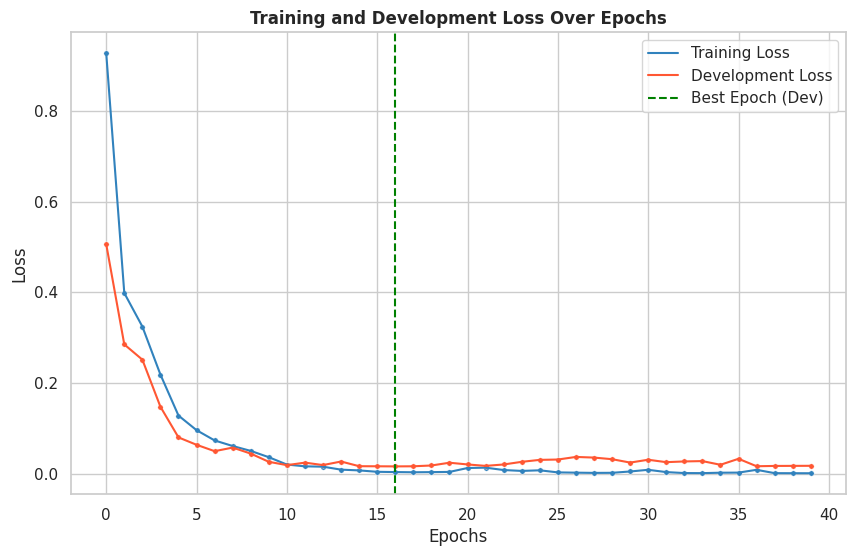

In [ ]:
# plot for Loss (Training and Development Sets)
create_metric_plot(epochs, train_loss_list, eval_loss_list, 'Training Loss', 'Development Loss', 'Training and Development Loss Over Epochs', best_epoch_loss_eval)

## Plot for Macro F1 Score (Training and Evaluation Sets) Over Epochs

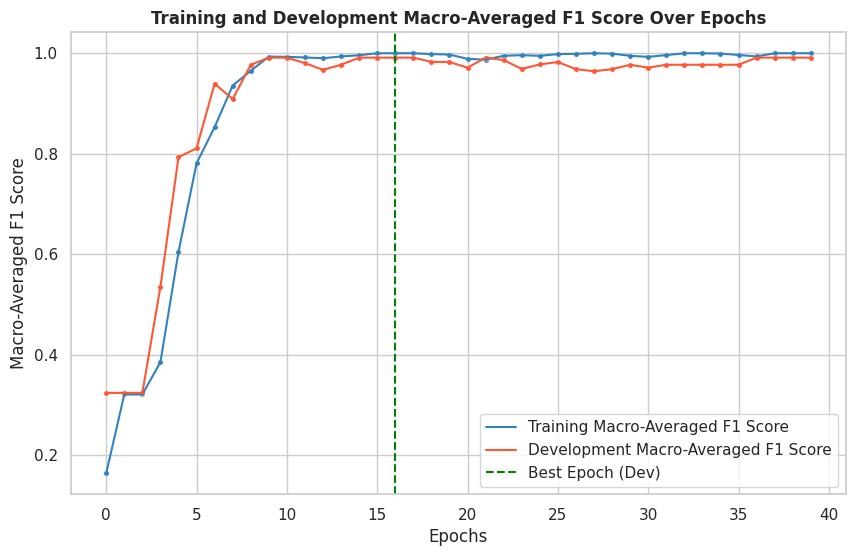

In [ ]:
# Plot for Macro F1 Score (Training and Development Sets)
create_metric_plot(epochs, train_avg_f1_list, eval_avg_f1_list, 'Training Macro-Averaged F1 Score', 'Development Macro-Averaged F1 Score', 'Training and Development Macro-Averaged F1 Score Over Epochs', best_epoch_loss_eval, ylabel="Macro-Averaged F1 Score")


## Plots for F1 Score for each Class "Other", "Price", "Date" on (Training and Evaluation Sets) Over Epochs

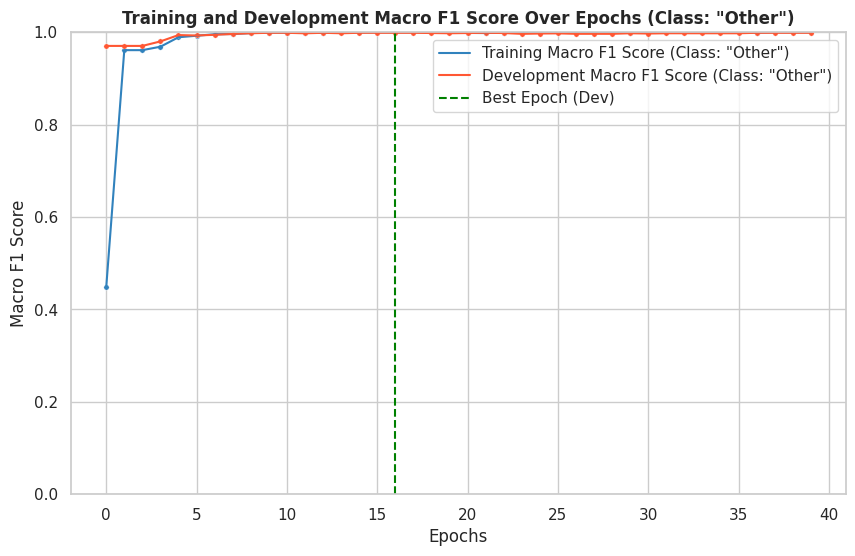

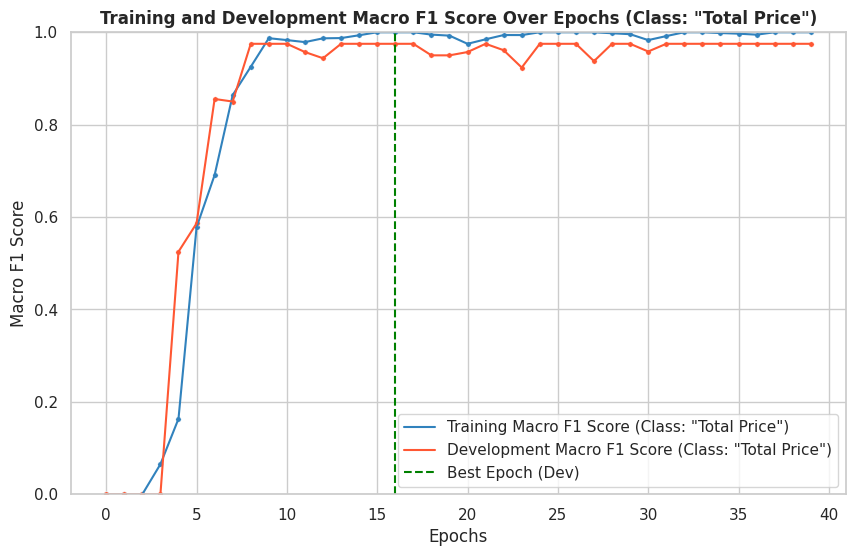

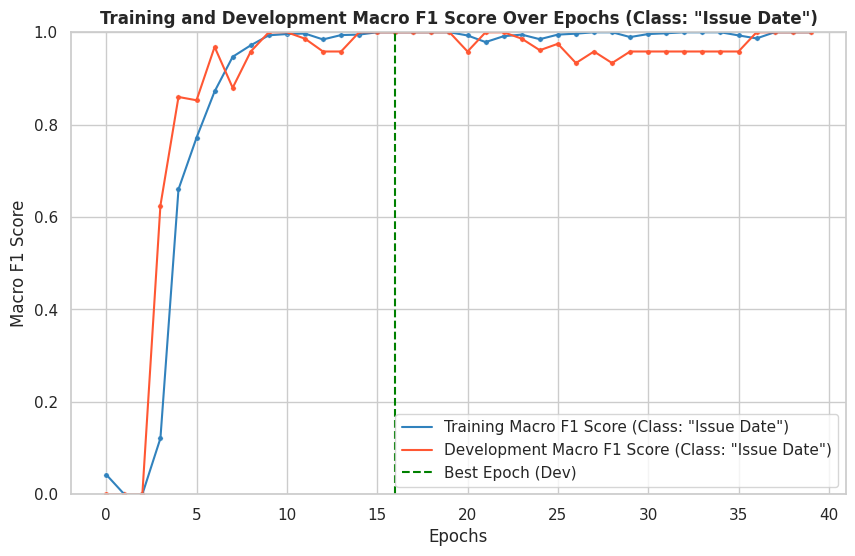

In [ ]:
# Plot for Macro F1 Score (Class: "Other") (Training and Development)
create_metric_plot(epochs, train_f1_0_list, eval_f1_0_list, 'Training Macro F1 Score (Class: "Other")', 'Development Macro F1 Score (Class: "Other")', 'Training and Development Macro F1 Score Over Epochs (Class: "Other")', best_epoch_loss_eval, ylim=f1_ylim, ylabel="Macro F1 Score")

# Plot for Macro F1 Score (Class: "Total Price") (Training and Development)
create_metric_plot(epochs, train_f1_1_list, eval_f1_1_list, 'Training Macro F1 Score (Class: "Total Price")', 'Development Macro F1 Score (Class: "Total Price")', 'Training and Development Macro F1 Score Over Epochs (Class: "Total Price")', best_epoch_loss_eval, ylim=f1_ylim, ylabel="Macro F1 Score")

# Plot for Macro F1 Score (Class: "Issue Date") (Training and Development)
create_metric_plot(epochs, train_f1_2_list, eval_f1_2_list, 'Training Macro F1 Score (Class: "Issue Date")', 'Development Macro F1 Score (Class: "Issue Date")', 'Training and Development Macro F1 Score Over Epochs (Class: "Issue Date")', best_epoch_loss_eval, ylim=f1_ylim, ylabel="Macro F1 Score")

## Plots for Precision Score for each Class "Other", "Price", "Date" on (Training and Evaluation Sets) Over Epochs

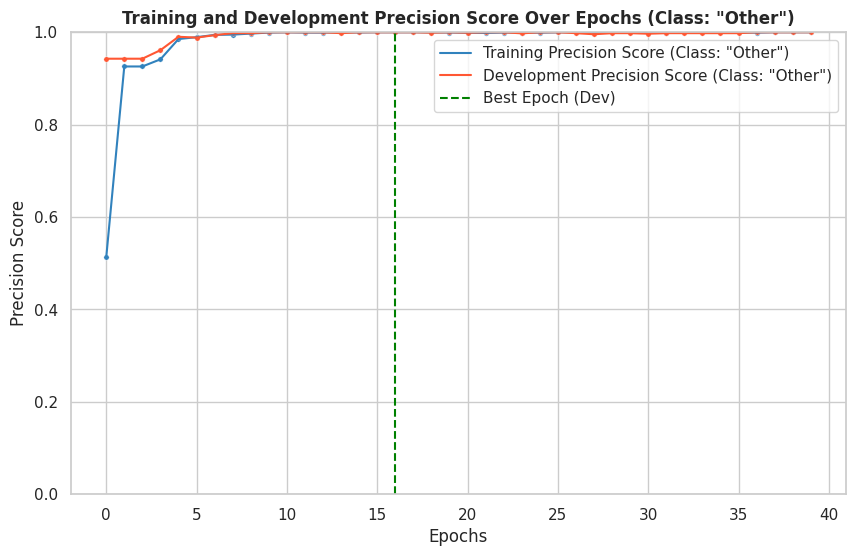

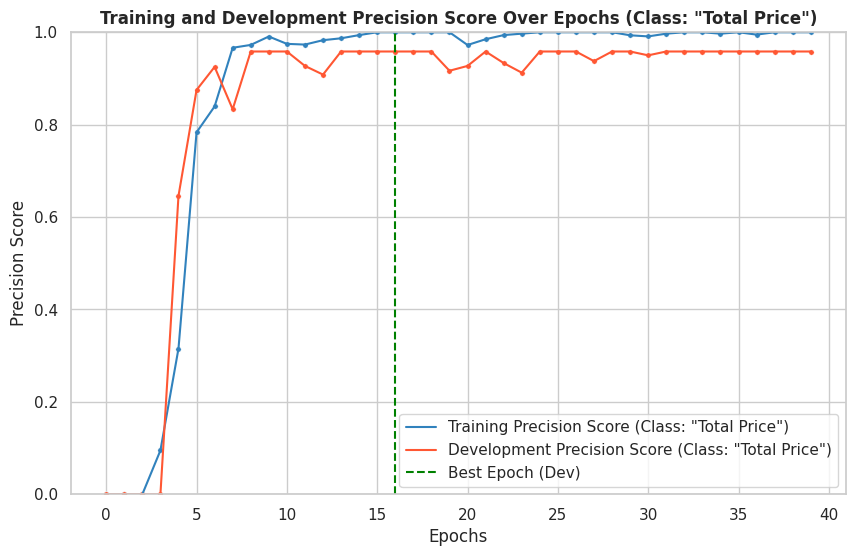

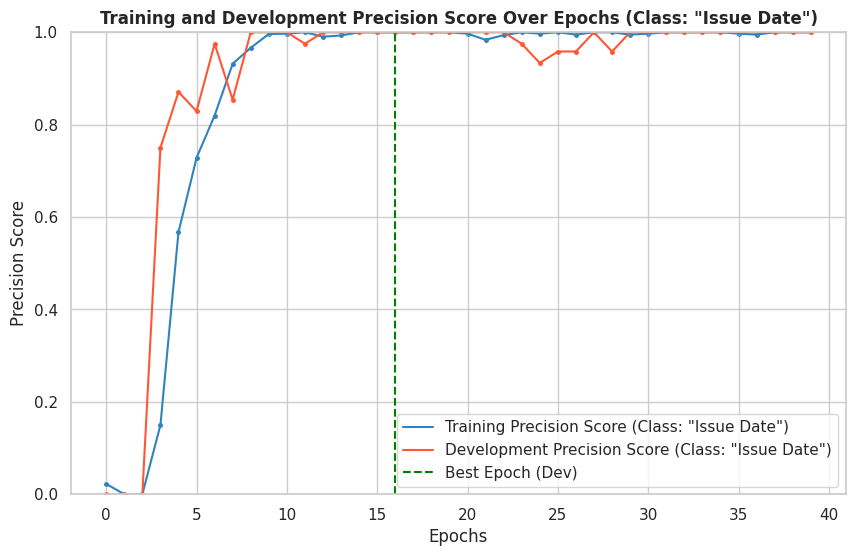

In [ ]:
# Plot for precision Score (Class: "Other") (Training and Development)
create_metric_plot(epochs, train_precision_0_list, eval_precision_0_list, 'Training Precision Score (Class: "Other")', 'Development Precision Score (Class: "Other")', 'Training and Development Precision Score Over Epochs (Class: "Other")', best_epoch_loss_eval, ylim=f1_ylim, ylabel="Precision Score")

# Plot for precision Score (Class: "Total Price") (Training and Development)
create_metric_plot(epochs, train_precision_1_list, eval_precision_1_list, 'Training Precision Score (Class: "Total Price")', 'Development Precision Score (Class: "Total Price")', 'Training and Development Precision Score Over Epochs (Class: "Total Price")', best_epoch_loss_eval, ylim=f1_ylim, ylabel="Precision Score")

# Plot for precision Score (Class: "Issue Date") (Training and Development)
create_metric_plot(epochs, train_precision_2_list, eval_precision_2_list, 'Training Precision Score (Class: "Issue Date")', 'Development Precision Score (Class: "Issue Date")', 'Training and Development Precision Score Over Epochs (Class: "Issue Date")', best_epoch_loss_eval, ylim=f1_ylim, ylabel="Precision Score")

## Plots for Recall Score for each Class "Other", "Price", "Date" on (Training and Evaluation Sets) Over Epochs

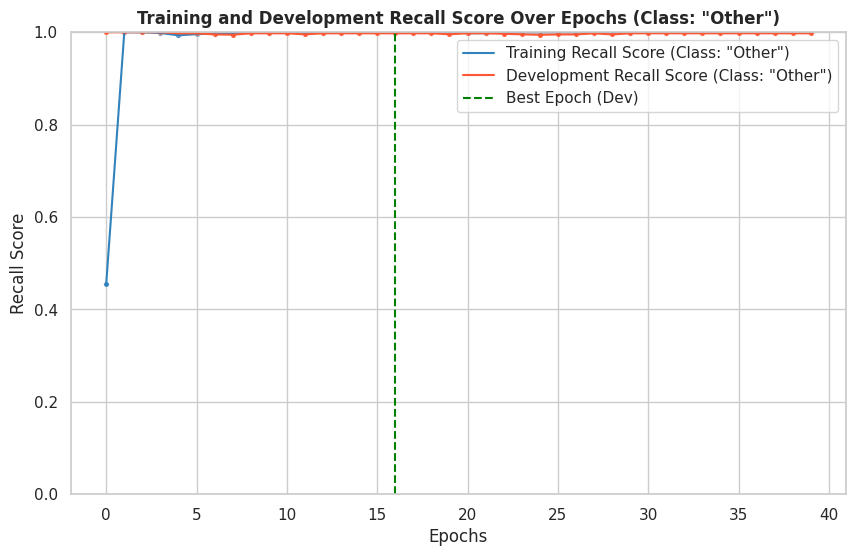

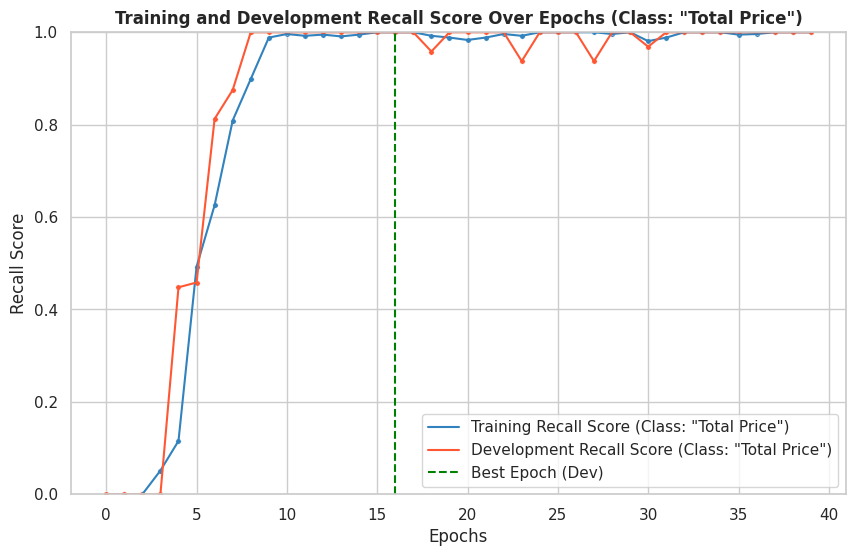

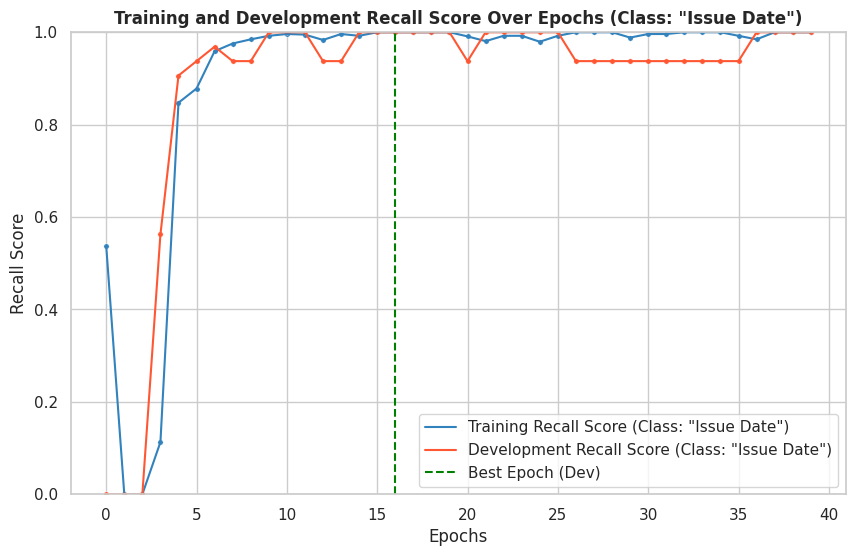

In [ ]:

# Plot for Recall Score (Class: "Other") (Training and Development)
create_metric_plot(epochs, train_recall_0_list, eval_recall_0_list, 'Training Recall Score (Class: "Other")', 'Development Recall Score (Class: "Other")', 'Training and Development Recall Score Over Epochs (Class: "Other")', best_epoch_loss_eval, ylim=f1_ylim, ylabel="Recall Score")

# Plot for Recall Score (Class: "Total Price") (Training and Development)
create_metric_plot(epochs, train_recall_1_list, eval_recall_1_list, 'Training Recall Score (Class: "Total Price")', 'Development Recall Score (Class: "Total Price")', 'Training and Development Recall Score Over Epochs (Class: "Total Price")', best_epoch_loss_eval, ylim=f1_ylim, ylabel="Recall Score")

# Plot for Recall Score (Class: "Issue Date") (Training and Development)
create_metric_plot(epochs, train_recall_2_list, eval_recall_2_list, 'Training Recall Score (Class: "Issue Date")', 'Development Recall Score (Class: "Issue Date")', 'Training and Development Recall Score Over Epochs (Class: "Issue Date")', best_epoch_loss_eval, ylim=f1_ylim, ylabel="Recall Score")

# Inference

## Creating the Necessary Functions

We need some functions to visualize the results of our model on an image:


* process_image: This function takes the image path, the model, and the processor as inputs. It outputs the predicted labels for each bounding box, excluding predictions for special tokens such as [PAD], [SEP], and [PAD]. These tokens are identified by predicted bounding box coordinates always being [0, 0, 0, 0], as specified in the Hugging Face documentation here: https://huggingface.co/docs/transformers/en/model_doc/layoutlmv3#transformers.LayoutLMv3Processor.

* generate_bounding_boxes: Given the image path, class_id_list from the previous function, and the OCR engine, this function provides a list with corrected bounding boxes. The OCR engine is used to accurately obtain bounding boxes without normalization issues.

* draw_plot: The final function takes the image path, class_id_list, and bounding_boxes as inputs. It generates and displays the image with the model's predictions. This function visually represents the results on the image using bounding boxes and associated class labels.


* dataSetFormat: This function initializes PaddleOCR for text detection and recognition with specific settings. It takes an image file as input, utilizes PaddleOCR to perform text detection and recognition, and organizes the results into a dictionary. This dictionary includes the image path, a list of tokens extracted from the detected text, and a list of bounding boxes in LayoutLM format. The function then returns this formatted dataset along with the original width and height of the input image.

A critical aspect of the inference process is to provide the model with bounding boxes in a format consistent with its training data. To achieve this, two additional functions were created:

* process_bbox: This function transforms the bounding box coordinates obtained from OCR into the format expected by Labels Studio. It ensures that the coordinates are represented as x, y, width, and height, aligning with the output format of Labels Studio.

* scale_bounding_box: This function serves a dual purpose. Firstly, it normalizes the bounding box coordinates (x, y, width, height) according to Label Studio standards. Secondly, it transforms these normalized coordinates into the format utilized by LayoutLM, specifically x1, y1, x2, y2, ensuring seamless compatibility with the model's learning structure.

In [ ]:
import torch
import pandas as pd
import numpy as np
from PIL import Image
import torch.nn.functional as nnf

def process_image(img_path, model, processor):
    # load image
    image = Image.open(img_path)

    # convert image to the required format
    test_dict, _, _ = dataSetFormat(image)

    # encode image using processor
    encoding = processor(
        test_dict['img_path'].convert('RGB'),
        test_dict['tokens'],
        boxes=test_dict['bboxes'],
        max_length=512,
        padding="max_length", truncation=True, return_tensors='pt',
        return_offsets_mapping=True
    )

    # extract necessary components from the encoding
    inputs_ids = encoding['input_ids'].flatten().long()
    attention_mask = encoding['attention_mask'].flatten().long()
    bbox = encoding['bbox'].flatten(end_dim=1).long()
    pixel_values = encoding['pixel_values'].flatten(end_dim=1).float()

    # make predictions using the model
    with torch.no_grad():
        op = model(
            input_ids=inputs_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0),
            bbox=bbox.unsqueeze(0),
            pixel_values=pixel_values.unsqueeze(0)
        )

    # process model outputs
    prob = nnf.softmax(op, dim=-1)
    pred_labels = prob.argmax(dim=-1).view(-1)

    # create dataframes from predictions
    bbox_whole = bbox.clone()
    pred_labels_whole = pred_labels.clone()

    bbox_df = pd.DataFrame({
        'x_min': bbox_whole[:, 0].tolist(),
        'y_min': bbox_whole[:, 1].tolist(),
        'x_max': bbox_whole[:, 2].tolist(),
        'y_max': bbox_whole[:, 3].tolist(),
    })

    pred_labels_df = pd.DataFrame({
        'class_id': pred_labels_whole.tolist()
    })

    prob_array = prob.squeeze().numpy()
    prob_df = pd.DataFrame(prob_array, columns=[f'prob_{i}' for i in range(prob_array.shape[1])])
    combined_df = pd.concat([bbox_df, pred_labels_df, prob_df], axis=1)

    # drop duplicates and rows with all zero coordinates as these are the cordinated for the [PAD], [SEP], and [PAD] tokens
    combined_df = combined_df.drop_duplicates(subset=['x_min', 'x_max', 'y_min', 'y_max'])
    combined_df = combined_df[~((combined_df['x_min'] == 0) & (combined_df['x_max'] == 0) & (combined_df['y_min'] == 0) & (combined_df['y_max'] == 0))]

    # reset the index
    combined_df = combined_df.reset_index(drop=True)

    # extract class_ids
    class_id_lists = combined_df['class_id'].tolist()

    return class_id_lists


In [ ]:
def generate_bounding_boxes(img_path, class_id_lists, ocr):
    # open image and convert to numpy array
    img = Image.open(img_path)
    img_np = np.asarray(img)
    image_height, image_width = img_np.shape[:2]

    # use OCR to detect text and obtain bounding boxes
    result = ocr.ocr(img_np, cls=False)

    # list to store corrected bounding box coordinates and labels
    bounding_boxes = []

    # iterate over OCR results and process each detected text region
    for i, output in enumerate(result):
        for j, item in enumerate(output):
            co_ord = item[0]
            four_co_ord = [co_ord[0][0], co_ord[1][1], co_ord[2][0] - co_ord[0][0], co_ord[2][1] - co_ord[1][1]]

            # assign correct label based on the order of detection
            label = class_id_lists[len(bounding_boxes)]

            # normalize bounding box coordinates
            bbox = {
                'x': four_co_ord[0] / image_width,
                'y': four_co_ord[1] / image_height,
                'width': four_co_ord[2] / image_width,
                'height': four_co_ord[3] / image_height,
                'rotation': 0,
                'label': label
            }

            # convert to absolute coordinates
            bbox['x'] *= image_width
            bbox['y'] *= image_height
            bbox['width'] *= image_width
            bbox['height'] *= image_height

            # append bounding box information to the list
            bounding_boxes.append(bbox)

    return bounding_boxes

In [ ]:
def draw_plot(img_path, class_id_lists, bounding_boxes,save_path=None):
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt

    # convert image to numpy array
    img_np = np.asarray(Image.open(img_path))

    # create a subplot for visualization
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(img_np, cmap='gray')  # set cmap to 'gray' or 'viridis' for a neutral color map

    # iterate over bounding boxes and labels to draw rectangles and labels on the image
    for bbox in bounding_boxes:
        # determine color and label text based on class_id
        color = 'black' if bbox['label'] == 0 else 'red' if bbox['label'] == 1 else 'green'
        label_text = 'Other' if bbox['label'] == 0 else 'Total Price' if bbox['label'] == 1 else 'Issue Date'

        # create a rectangle patch for the bounding box
        rect = patches.Rectangle((bbox['x'], bbox['y']), bbox['width'], bbox['height'],
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        # add text label above the bounding box
        ax.text(bbox['x'] + bbox['width'] / 2, bbox['y'] - 5, f"{label_text}", color=color,
                fontsize=8, ha='center', va='bottom')

    # if save_path is provided, save the image
    if save_path:
        plt.axis('off')
        plt.savefig(save_path,bbox_inches='tight')
    else:
        plt.axis('off')
        plt.show()

In [ ]:
# function to scale bounding box coordinates based on image width and height
def scale_bounding_box(box:list[int], width:float, height:float) -> list[int]:
    return [
        100 * box[0] / width,
        100 * box[1] / height,
        (100 * box[0] / width) + box[2],
        (100 * box[1] / height) + box[3]
    ]

In [ ]:
from paddleocr import PaddleOCR

# setting up PaddleOCR for text detection and recognition
ocr = PaddleOCR(use_angle_cls=False, lang='en', rec=True)

# function to format dataset for model input
def dataSetFormat(img_file):
    width, height = img_file.size
    ress = ocr.ocr(np.asarray(img_file))
    #print("ress", ress)
    test_dict = {'tokens':[], "bboxes":[]}
    test_dict['img_path'] = img_file
    for item in ress[0]:
        test_dict['tokens'].append(item[1][0])
        test_dict['bboxes'].append(scale_bounding_box(process_bbox(item[0]), width, height))
    return test_dict, width, height

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:15<00:00, 259kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10.2M/10.2M [00:16<00:00, 613kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:14<00:00, 156kiB/s]

[2024/01/02 19:17:31] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='

In [ ]:
# function to process bounding box format
def process_bbox(box:list):
        return [
        box[0][0],            # x-coordinate of the top-left corner
        box[1][1],            # y-coordinate of the top-left corner
        box[2][0] - box[0][0], # width of the rectangle
        box[2][1] - box[1][1]  # height of the rectangle
    ]

For the inference process, we need to reinitialize the model, as only the output is required, and there is no need to return any other metrics.

In [ ]:
import torch.nn as nn
import torch.nn.functional as nnf
from sklearn.metrics import precision_recall_fscore_support

# defining the custom neural network module
class ModelModule(nn.Module):
    def __init__(self, n_classes: int) -> None:
        super().__init__()
        # loading the LayoutLMv3 model for token classification
        self.model = LayoutLMv3ForTokenClassification.from_pretrained('microsoft/layoutlmv3-base')

        # Removing the final layer of the LayoutLMv3 model
        in_features_layoutlm = self.model.classifier.in_features
        self.model.classifier = nn.Identity()

        # adding a custom classification layer with gradual increase in features
        self.cls_layer = nn.Sequential(
            nn.Linear(in_features=768, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=n_classes)
        )

    def forward(self, input_ids, attention_mask, bbox, pixel_values):
        # passing input features through the LayoutLMv3 model
        output = self.model(input_ids, bbox=bbox, pixel_values=pixel_values)
        # passing the flattened logits through the custom classification layer
        output = self.cls_layer(output.logits)
        # calculating cross-entropy loss and F1 scores
        return output


In [ ]:
# Loading the Model with the trained weights
model = ModelModule(3)
model.load_state_dict(torch.load(os.path.join(my_wd, "drive/your_path.bin")))

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

## For a Folder

### Creating a Function for Performing Infernce for a Folder

In [ ]:
import os
from tqdm import tqdm

def process_images_in_folder(input_folder, output_folder, model, processor, ocr):
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all files in the input folder
    for filename in tqdm(os.listdir(input_folder)):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            # Build the full path for the input image
            input_path = os.path.join(input_folder, filename)

            # Process the image
            class_id_lists = process_image(input_path, model, processor)

            # Generate bounding boxes
            bounding_boxes = generate_bounding_boxes(input_path, class_id_lists, ocr)

            # Build the full path for the output image
            output_path = os.path.join(output_folder, filename)

            # Draw plot and save the output image
            draw_plot(input_path, class_id_lists, bounding_boxes, save_path=output_path)

### Utilizing the Function

In [ ]:
# set the inputs
input_folder = os.path.join(my_wd, "Your Input Folder")
output_folder = os.path.join(my_wd, "Your Output Folder")
img_model = model
img_processor = processor
ocr = ocr

# utilize the function
process_images_in_folder(input_folder, output_folder, img_model, img_processor, ocr)

Zipping the Results for Easy Download

In [ ]:
import shutil
shutil.make_archive(output_folder, 'zip', output_folder)

'/content/Final Invoices Dataset - PNG - Extended | Results Random State 42.zip'